In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='squared_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features='sqrt')
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.001)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1E-4, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_All.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'A_site' 'B_site' 'X_site' 'Spacegroup' 'Ehull' 'BulkModulus'
 'Energy' 'ZPE' 's_A' 's_B' 's_X' 'density' 'mean_A2B' 'mean_A2X'
 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X' 'std_B2X' 'std_X2X' 'E_coh'
 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M' 'A_G' 'B_G' 'X_G' 'A_IEI'
 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII' 'A_EA' 'B_EA' 'X_EA' 'A_ChiP'
 'B_ChiP' 'X_ChiP' 'A_ChiA' 'B_ChiA' 'X_ChiA' 'A_Rvdw' 'B_Rvdw' 'X_Rvdw'
 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra' 'A_MP' 'B_MP' 'X_MP' 'A_BP'
 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'X_Rho' 'A_MV' 'B_MV' 'X_MV' 'A_Hf' 'B_Hf'
 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa' 'X_Kappa' 'A_CvM' 'B_CvM'
 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo' 'B_MendeleevNo' 'X_MendeleevNo'
 'Coeff_A' 'Coeff_B' 'Coeff_C' 'Coeff_D']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coeff_A', 'Coeff_C', 'Coeff_D'], axis=1, inplace = True)
target = 'Coeff_B'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 53)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.8976208864435138
RMSE:  0.3309371244039687
RMSE unscaled:  1.854396653975928e-05
----------------------------------------


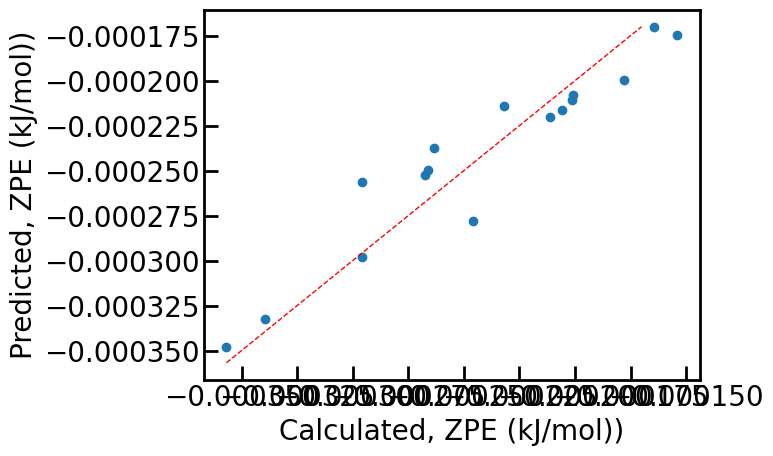

GB 0.9220261137293329
RMSE:  0.2888114430990843
RMSE unscaled:  1.6183466109385163e-05
----------------------------------------


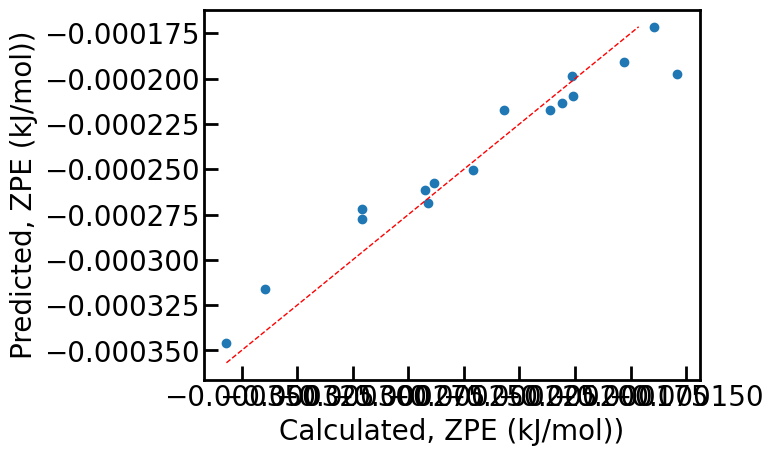

RR 0.7275452407315903
RMSE:  0.5398672787085459
RMSE unscaled:  3.025130761715808e-05
----------------------------------------


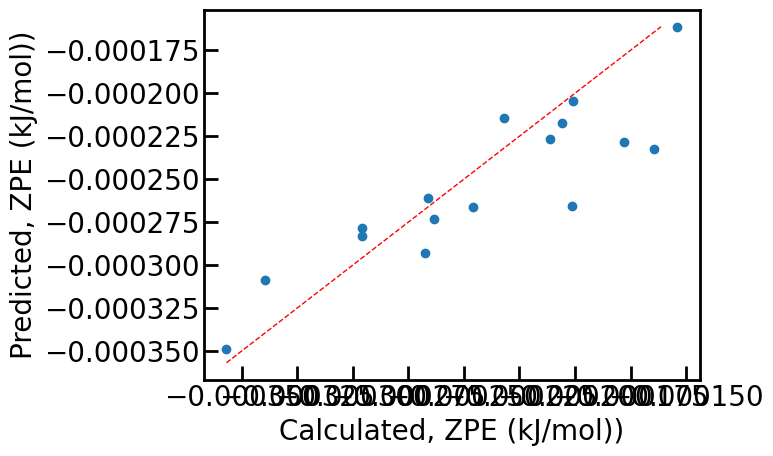

LASSO 0.9113227687605071
RMSE:  0.3079965620399538
RMSE unscaled:  1.7258498728773326e-05
----------------------------------------


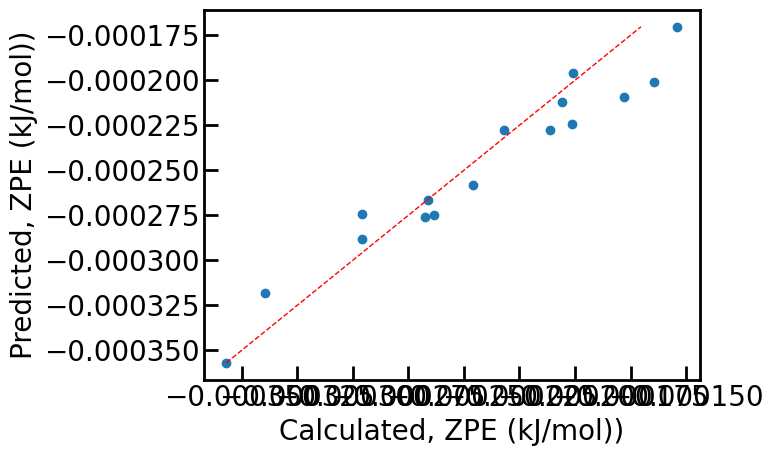

gpr1 0.8937264713280775
RMSE:  0.3371726637023306
RMSE unscaled:  1.8893373190084274e-05
----------------------------------------


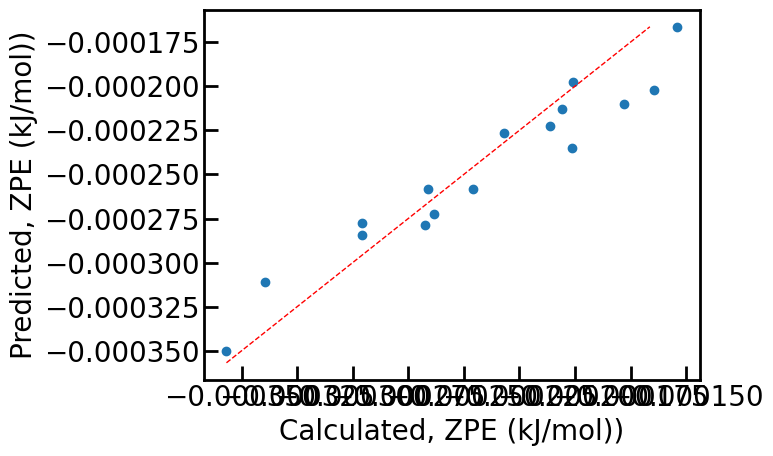

gpr2 0.949961836554563
RMSE:  0.23136117812602985
RMSE unscaled:  1.296425704277054e-05
----------------------------------------


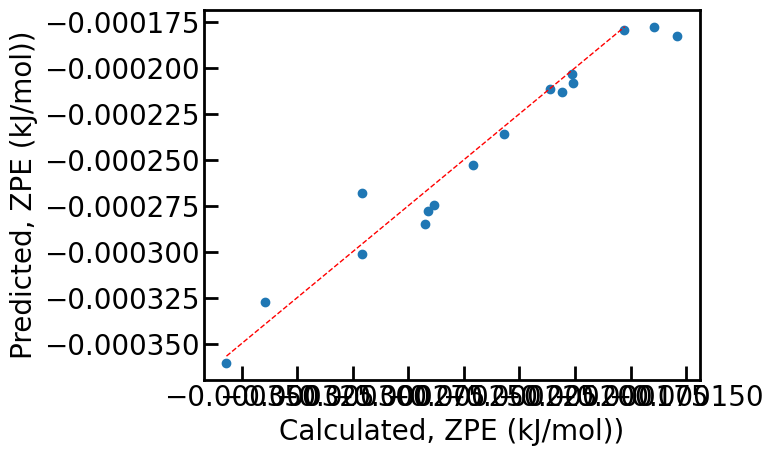

gpr3 0.95120828406111
RMSE:  0.22846140978075102
RMSE unscaled:  1.2801769357942944e-05
----------------------------------------


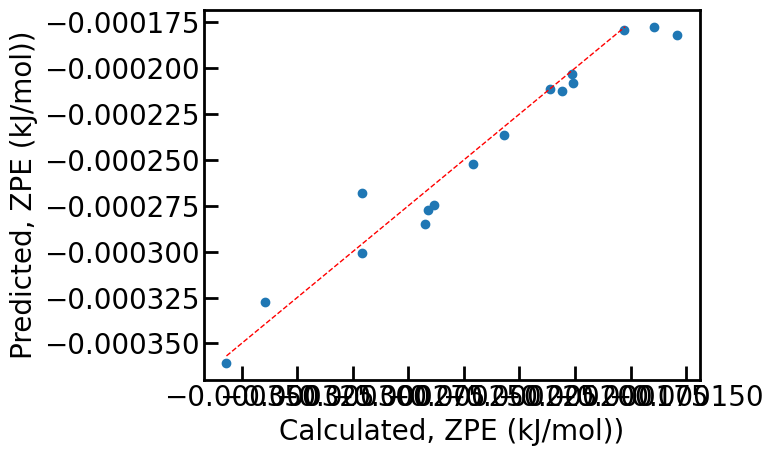

gpr4 0.9645045570396271
RMSE:  0.19486152926795888
RMSE unscaled:  1.0919009721678772e-05
----------------------------------------


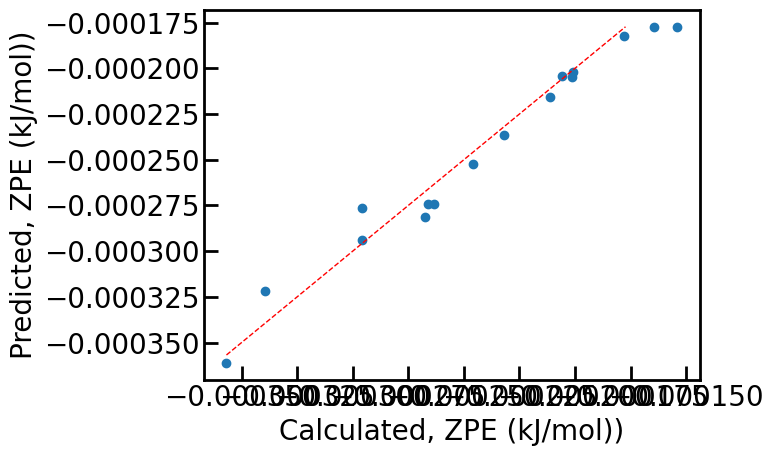

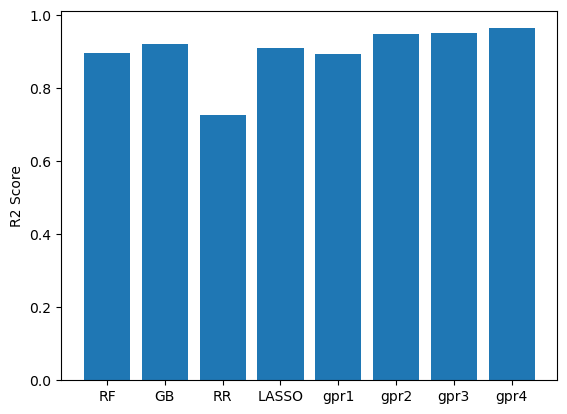

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
28      X_EA  107.076012
4   mean_A2B   99.929262
36      X_Ra   84.202321
2        s_X   82.062188
17       X_Z   79.740038
7   mean_X2X   53.239994
1        s_B   48.879012
34    A_Rvdw   39.367219
5   mean_A2X   37.109735
0        s_A   33.458100
20     A_IEI   26.852117
12     E_coh   26.552367
31    A_ChiA   14.916445
44      B_Hf   13.952951
26      A_EA   12.978514
9    std_A2X   12.535370
41     X_Rho   12.379791
29    A_ChiP   12.150673
37      B_MP   11.671236
10   std_B2X   10.854134
32    B_ChiA    9.258006
38      A_BP    8.834299
14        OF    8.715184
16       B_Z    8.230539
47   X_Kappa    8.186239
45   A_Kappa    7.476652
46   B_Kappa    7.450582
35      B_Ra    7.059603
15       A_Z    6.801723
40     B_Rho    4.850823


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X', 'B_ChiA',
       'A_BP', 'OF', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra',
       'A_Z', 'B_Rho', 'X_MV', 'A_CvM', 'A_G', 'B_EA', 'X_ChiA', 'B_CvM',
       'TF', 'std_X2X', 'A_B', 'std_A2B'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.7699655117868575
RMSE:  0.49606236899135386
RMSE unscaled:  2.7796712105893512e-05
----------------------------------------


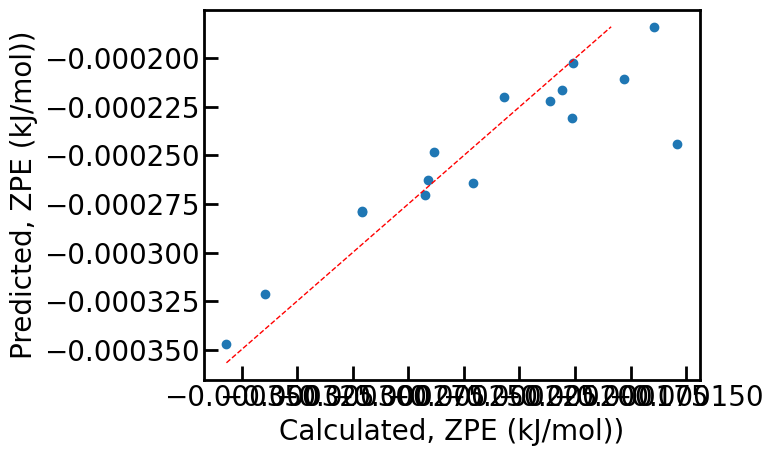

GB 0.873778860229907
RMSE:  0.36745643323614247
RMSE unscaled:  2.0590315501842785e-05
----------------------------------------


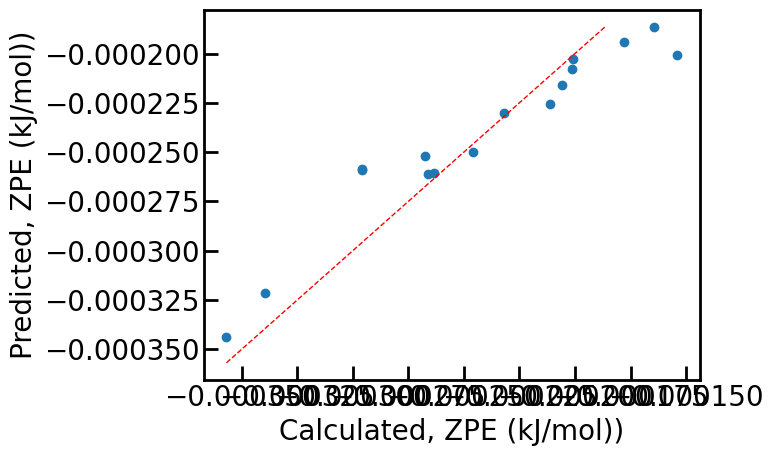

RR 0.9174729399761054
RMSE:  0.2971241780883793
RMSE unscaled:  1.6649267822544435e-05
----------------------------------------


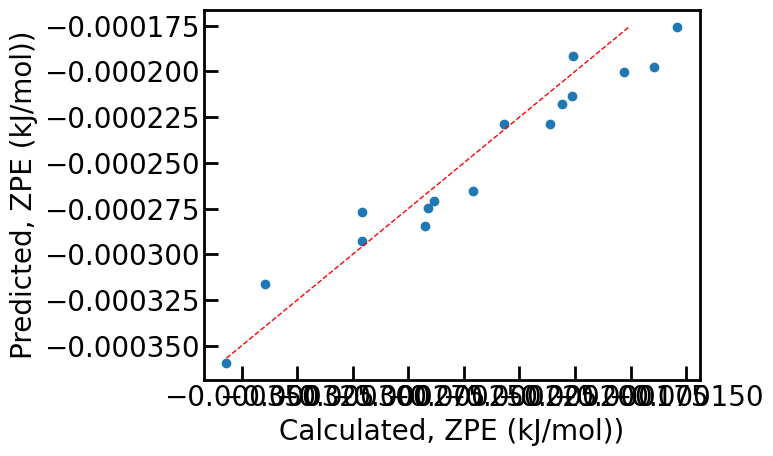

LASSO 0.9339848815153005
RMSE:  0.2657428020426044
RMSE unscaled:  1.4890821445721224e-05
----------------------------------------


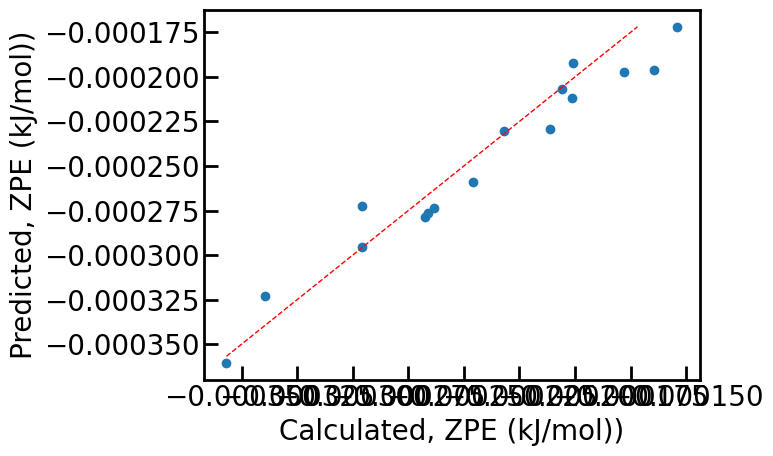

gpr1 0.9390313836080376
RMSE:  0.2553835831958722
RMSE unscaled:  1.4310345598480362e-05
----------------------------------------


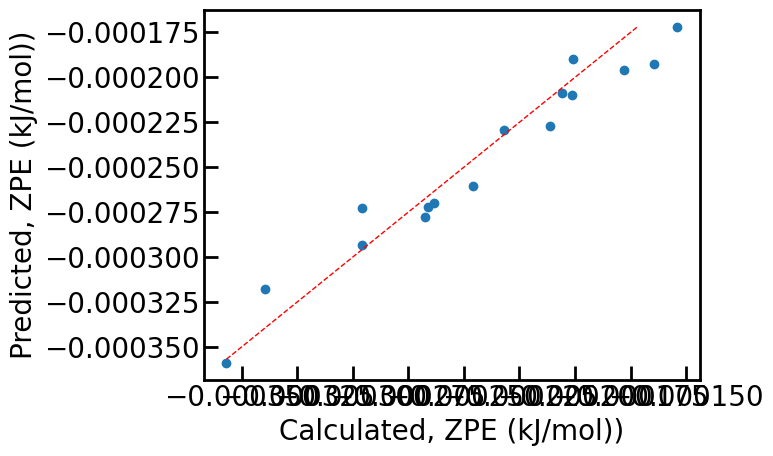

gpr2 0.9597822268796747
RMSE:  0.2074191338253181
RMSE unscaled:  1.1622671479635368e-05
----------------------------------------


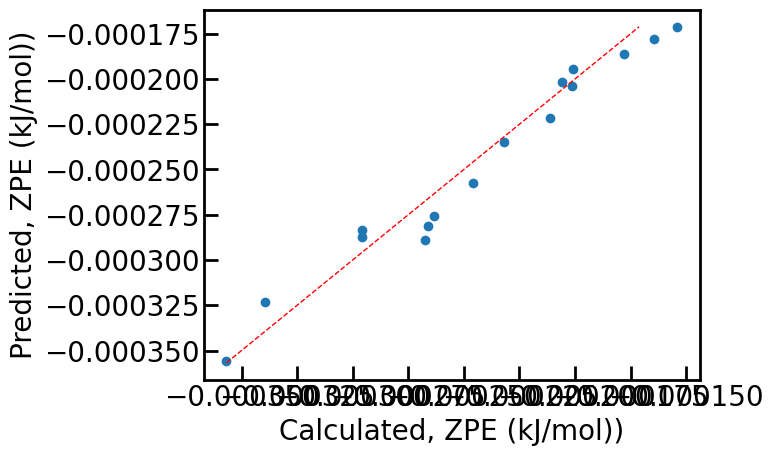

gpr3 0.9330367081105574
RMSE:  0.26764442656741766
RMSE unscaled:  1.4997378428782072e-05
----------------------------------------


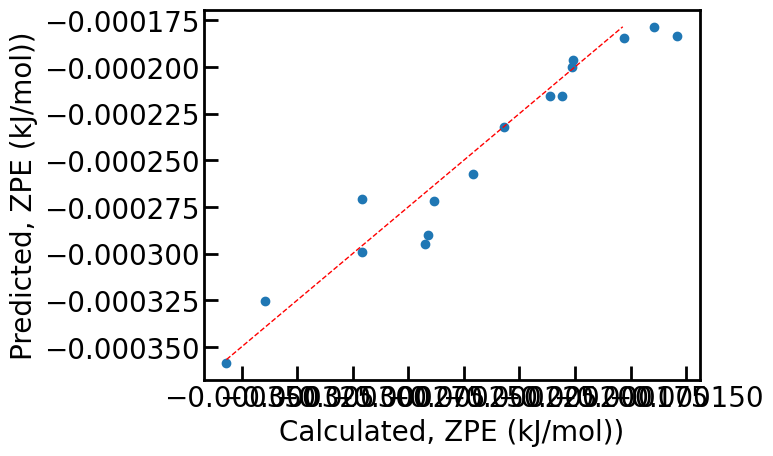

gpr4 0.9560047527600811
RMSE:  0.2169415245141607
RMSE unscaled:  1.2156255901843805e-05
----------------------------------------


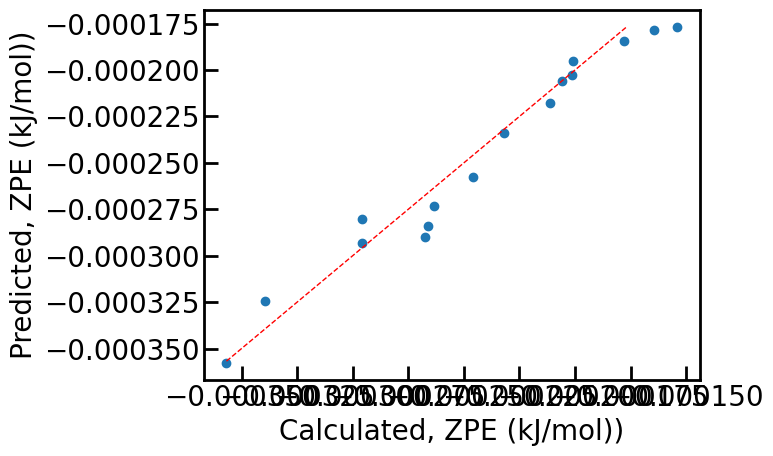

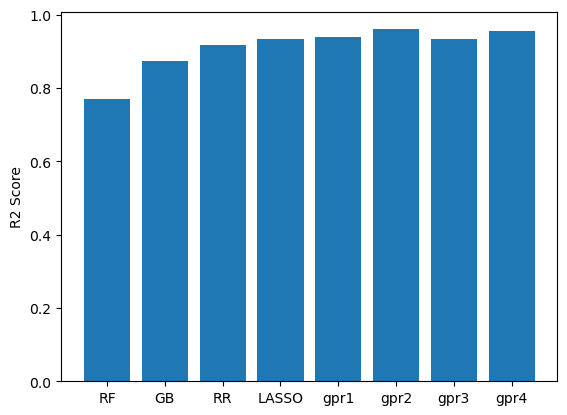

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X', 'B_ChiA',
       'A_BP', 'OF', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra',
       'A_Z', 'B_Rho'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.925482533470636
RMSE:  0.28233768342760096
RMSE unscaled:  1.5820710848999537e-05
----------------------------------------


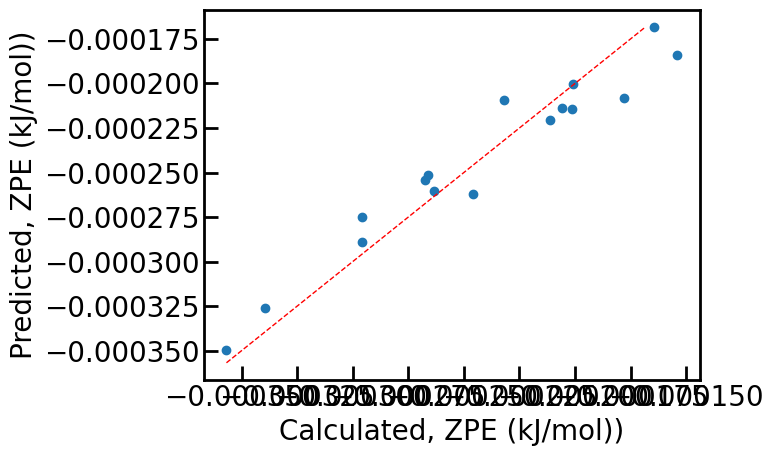

GB 0.865152137648895
RMSE:  0.3798060160278573
RMSE unscaled:  2.1282320820019182e-05
----------------------------------------


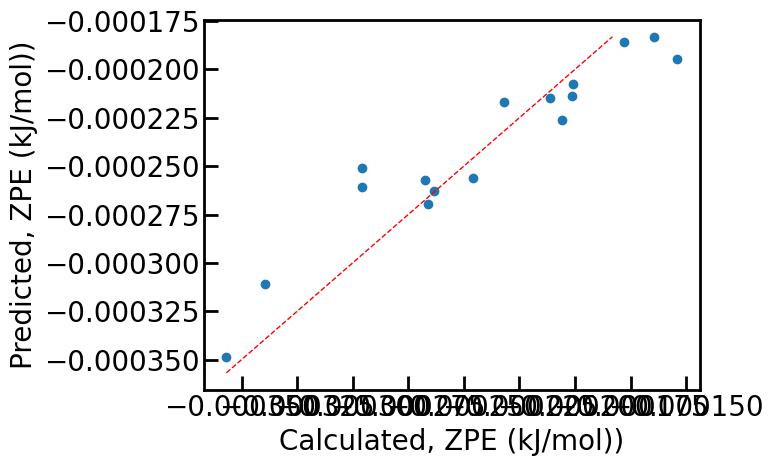

RR 0.9194221811989434
RMSE:  0.29359425962574753
RMSE unscaled:  1.6451469857214875e-05
----------------------------------------


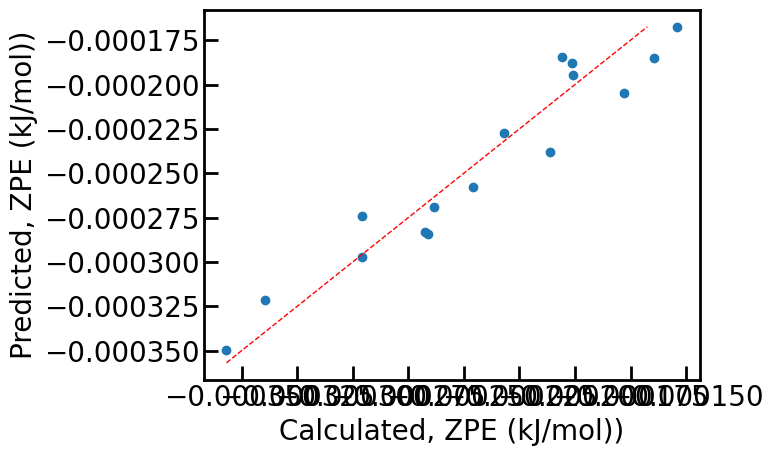

LASSO 0.9182903795735851
RMSE:  0.2956489922122352
RMSE unscaled:  1.6566606206455246e-05
----------------------------------------


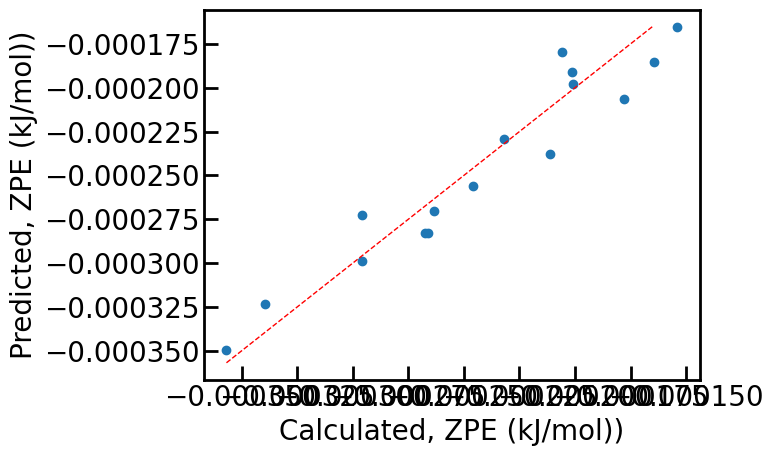

gpr1 0.9193704440041213
RMSE:  0.2936884996174082
RMSE unscaled:  1.6456750568030287e-05
----------------------------------------


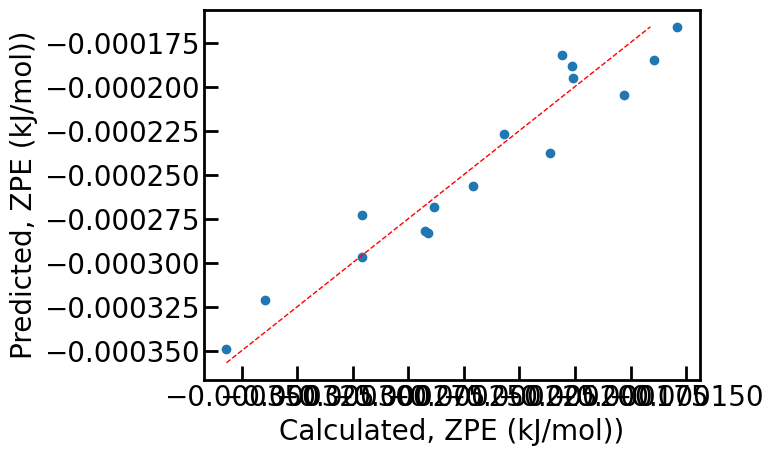

gpr2 0.9527764709267501
RMSE:  0.22476000138034438
RMSE unscaled:  1.2594362003295909e-05
----------------------------------------


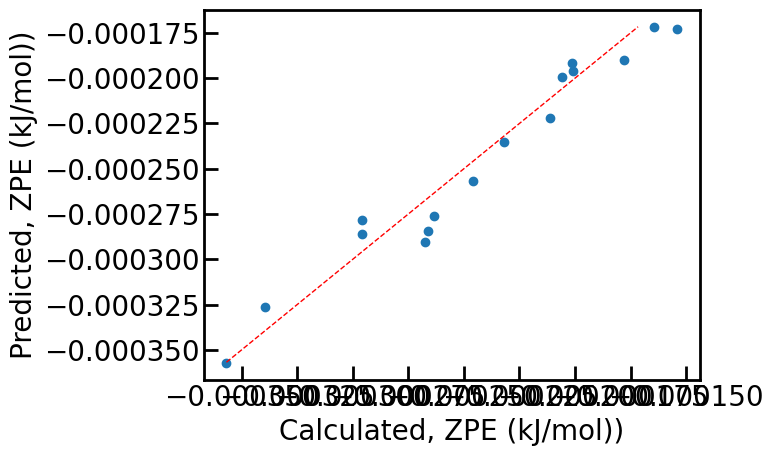

gpr3 0.9245434557950427
RMSE:  0.28411113956029377
RMSE unscaled:  1.592008595308802e-05
----------------------------------------


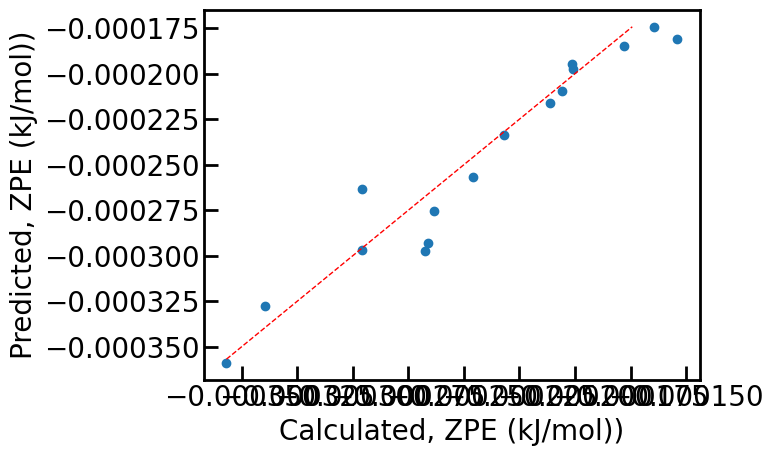

gpr4 0.9477406435090094
RMSE:  0.23644048157820668
RMSE unscaled:  1.3248874350158142e-05
----------------------------------------


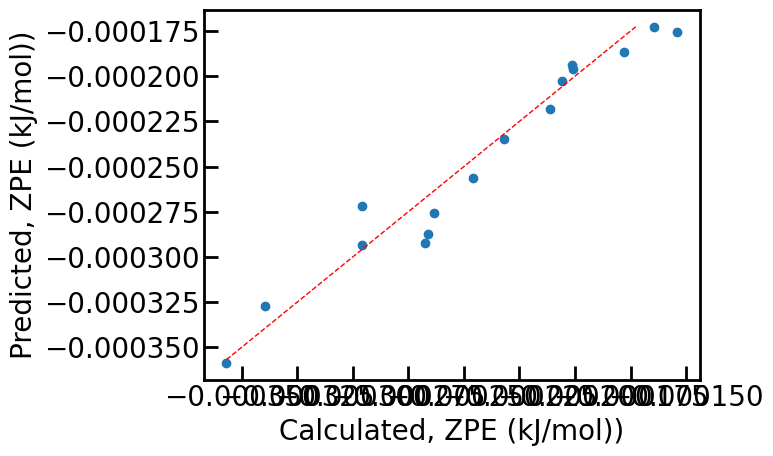

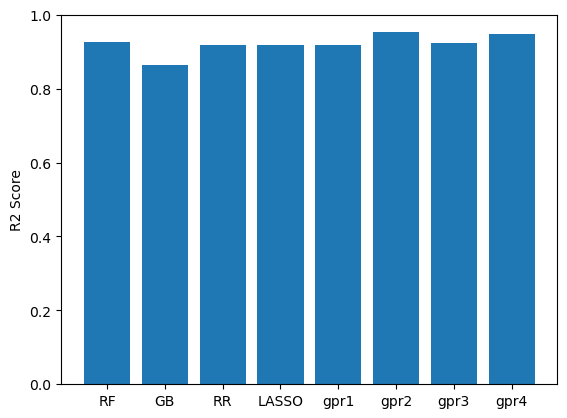

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X'],
      dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8435221830958265
RMSE:  0.40913458761769106
RMSE unscaled:  2.2925738889842382e-05
----------------------------------------


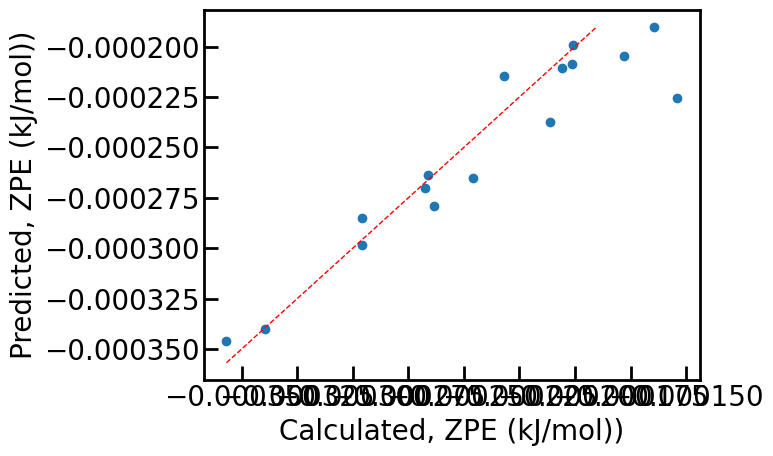

GB 0.8823799044449192
RMSE:  0.3547158300734177
RMSE unscaled:  1.9876399469691864e-05
----------------------------------------


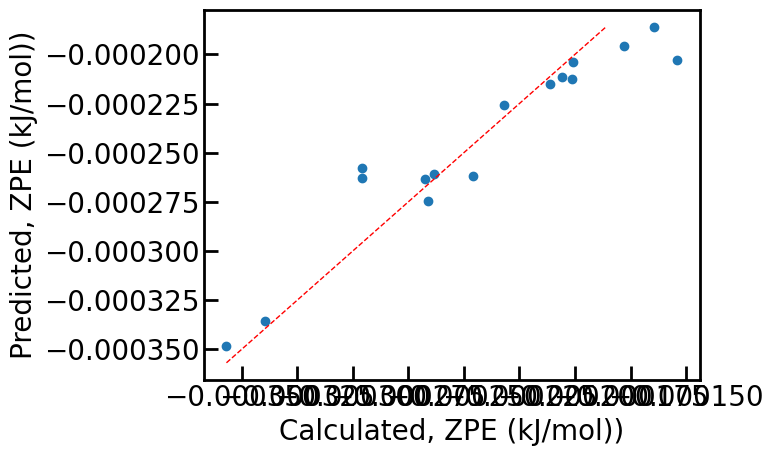

RR 0.9110555193934782
RMSE:  0.3084603223643118
RMSE unscaled:  1.7284485405103024e-05
----------------------------------------


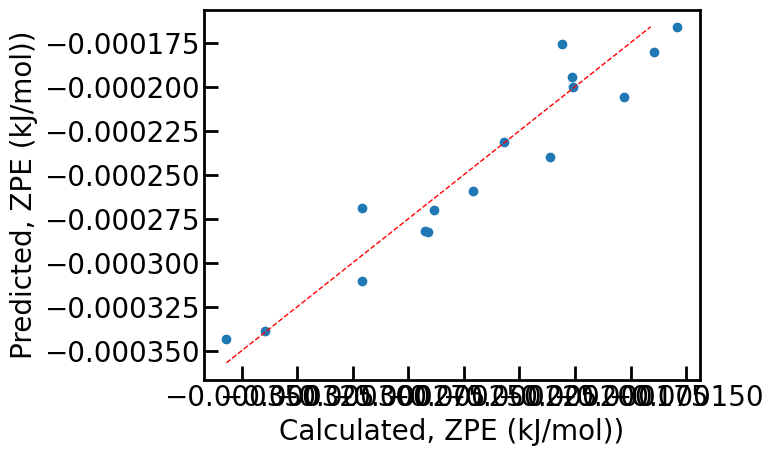

LASSO 0.9123379374661738
RMSE:  0.30622852939064765
RMSE unscaled:  1.715942752801583e-05
----------------------------------------


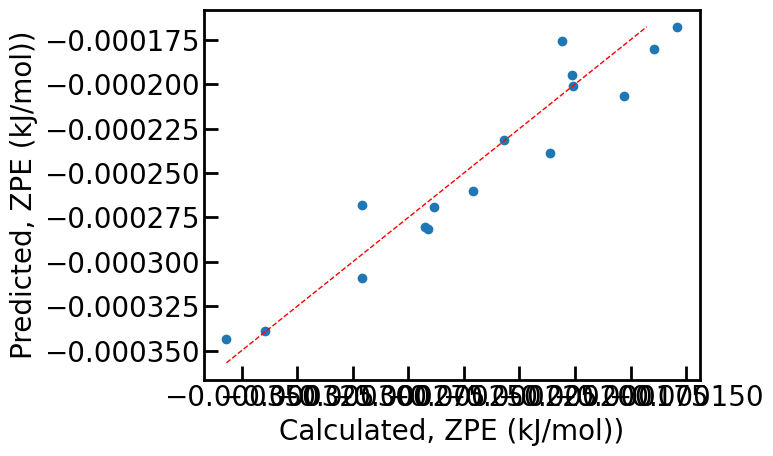

gpr1 0.9146324308722427
RMSE:  0.3021942968543959
RMSE unscaled:  1.6933370468685916e-05
----------------------------------------


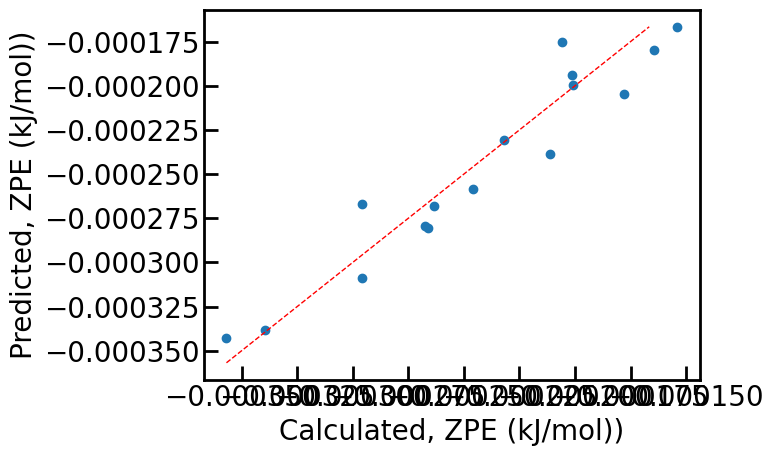

gpr2 0.9319128441960282
RMSE:  0.26988105726376255
RMSE unscaled:  1.5122707386267638e-05
----------------------------------------


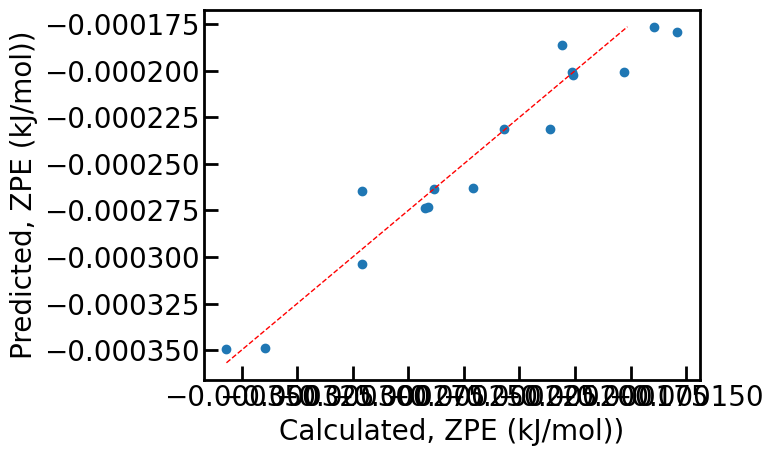

gpr3 0.9436687064786087
RMSE:  0.24547918254698955
RMSE unscaled:  1.3755355358083366e-05
----------------------------------------


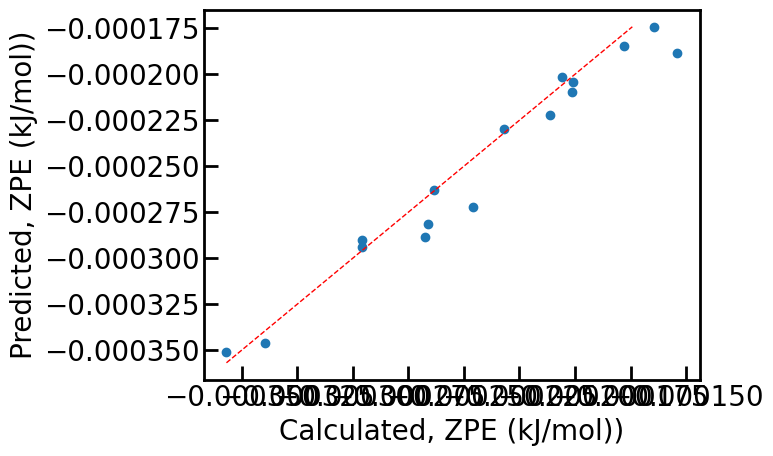

gpr4 0.9499605303944967
RMSE:  0.23136419774884295
RMSE unscaled:  1.2964426246465988e-05
----------------------------------------


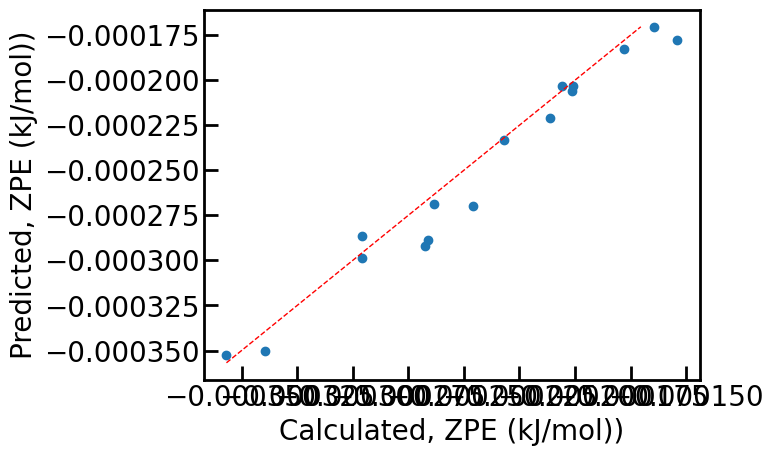

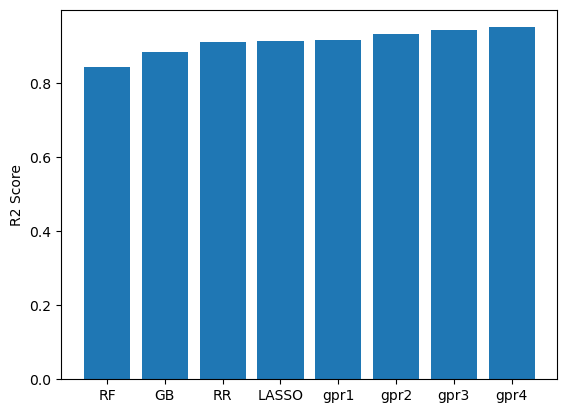

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8344439786182426
RMSE:  0.4208354310717465
RMSE unscaled:  2.358139228590592e-05
----------------------------------------


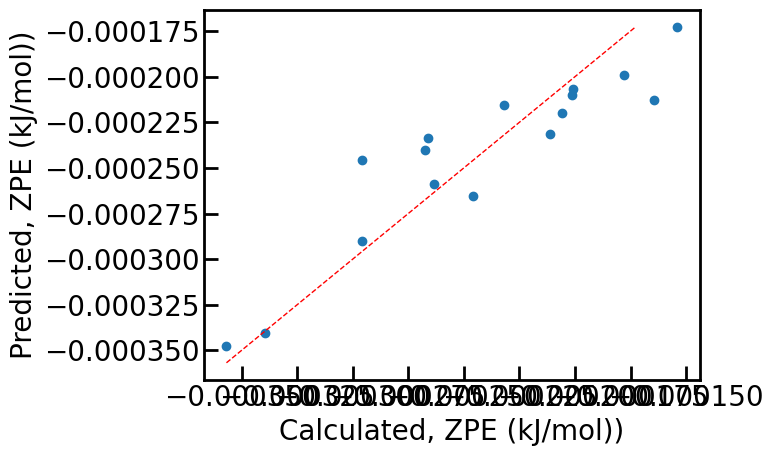

GB 0.8969605637541849
RMSE:  0.33200264478303304
RMSE unscaled:  1.8603672667599683e-05
----------------------------------------


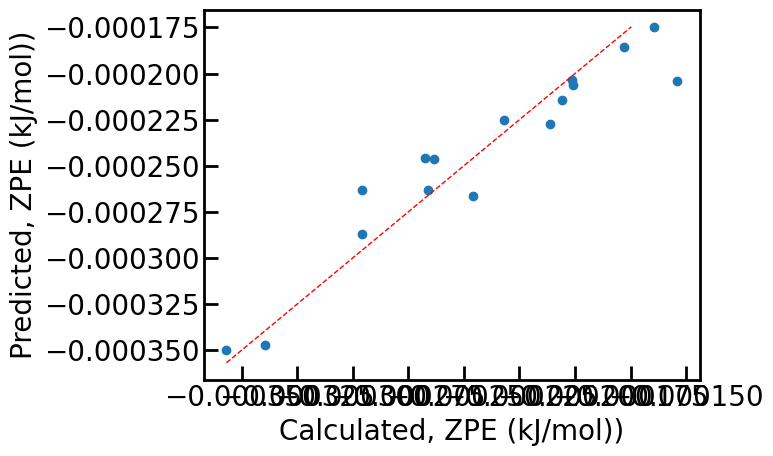

RR 0.9374736082956775
RMSE:  0.258625587315228
RMSE unscaled:  1.4492010366430992e-05
----------------------------------------


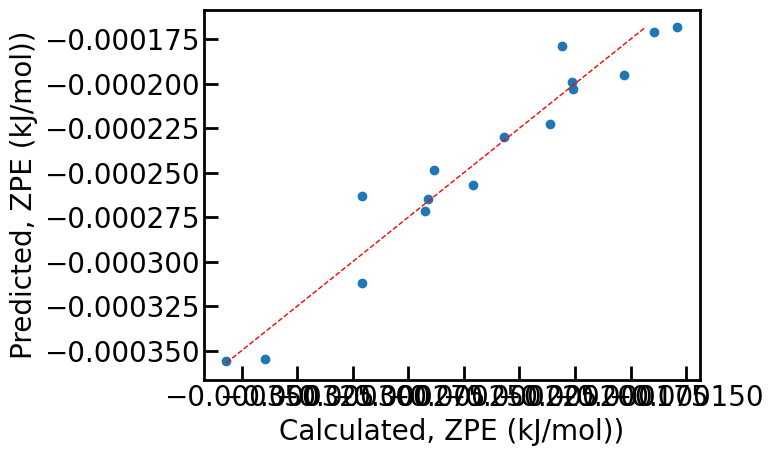

LASSO 0.9350118802260711
RMSE:  0.2636676160471423
RMSE unscaled:  1.4774538995594374e-05
----------------------------------------


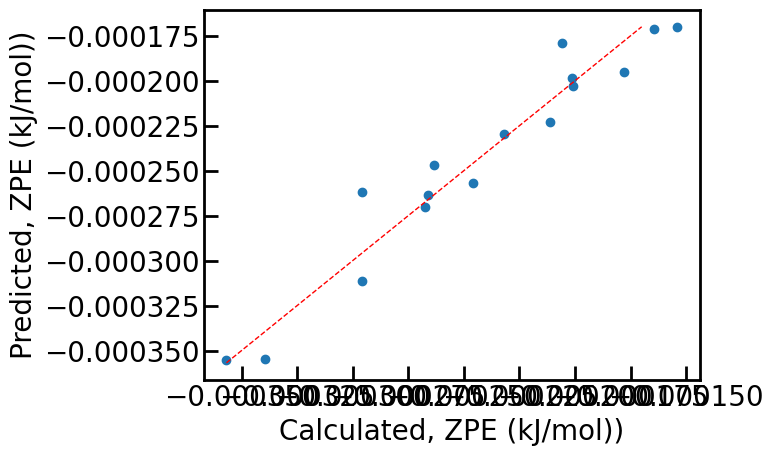

gpr1 0.9358727445053809
RMSE:  0.26191545940802624
RMSE unscaled:  1.4676357402499605e-05
----------------------------------------


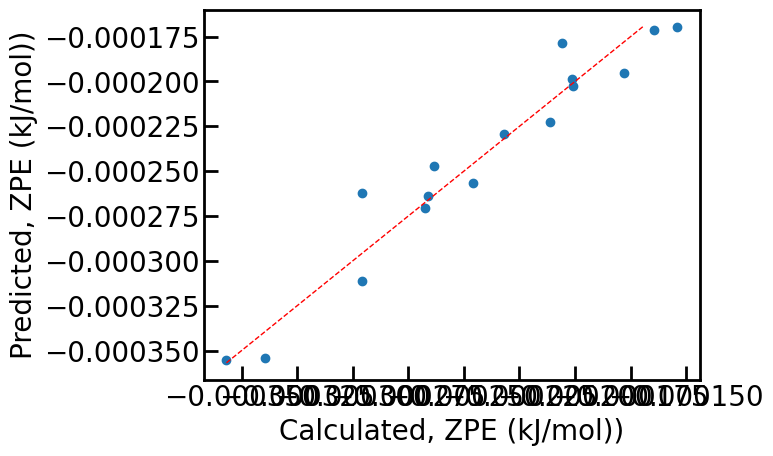

gpr2 0.9364779208948278
RMSE:  0.2606766664523388
RMSE unscaled:  1.460694199568681e-05
----------------------------------------


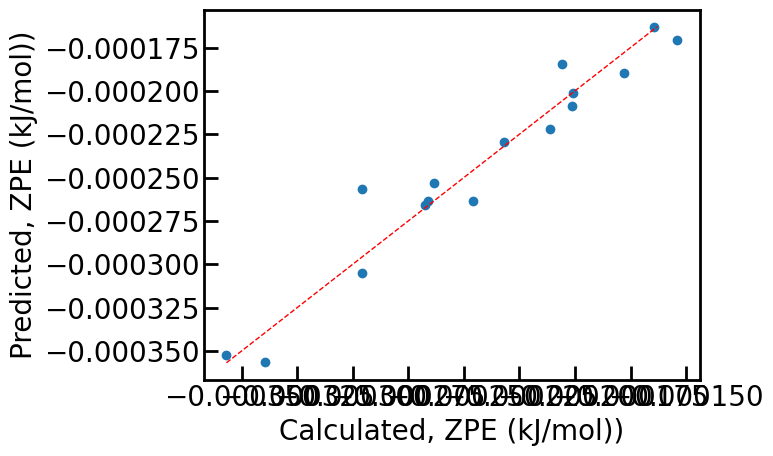

gpr3 0.9791229180192809
RMSE:  0.14944269976850566
RMSE unscaled:  8.37397867981603e-06
----------------------------------------


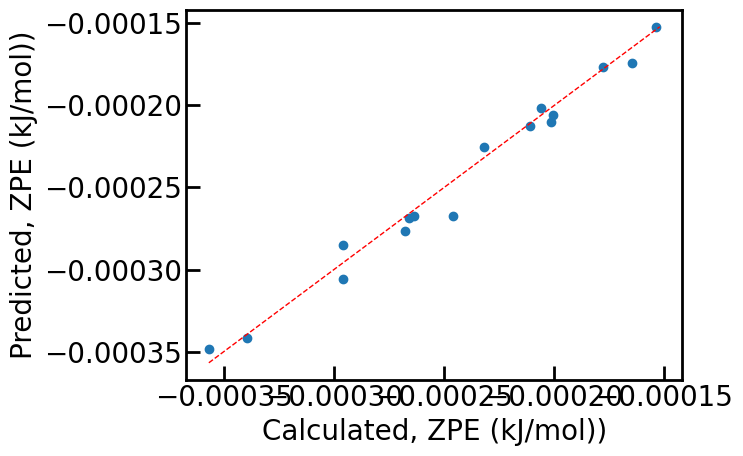

gpr4 0.9714534644201469
RMSE:  0.17474972912634887
RMSE unscaled:  9.792050787856997e-06
----------------------------------------


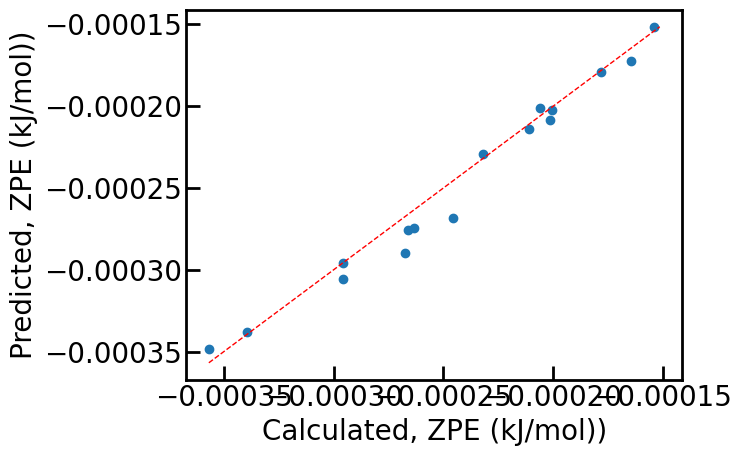

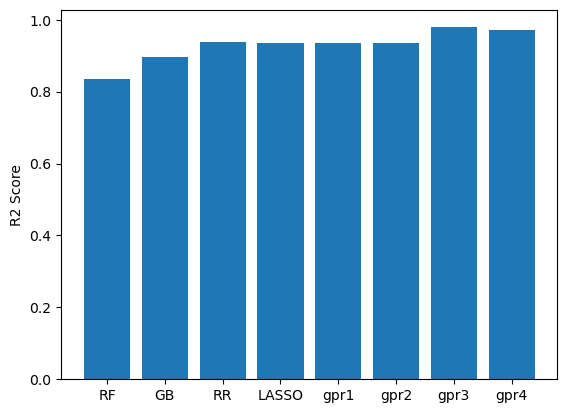

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 53)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.883875668734061
RMSE:  0.09522170439738716
RMSE unscaled:  1.9749611891676654e-05
----------------------------------------


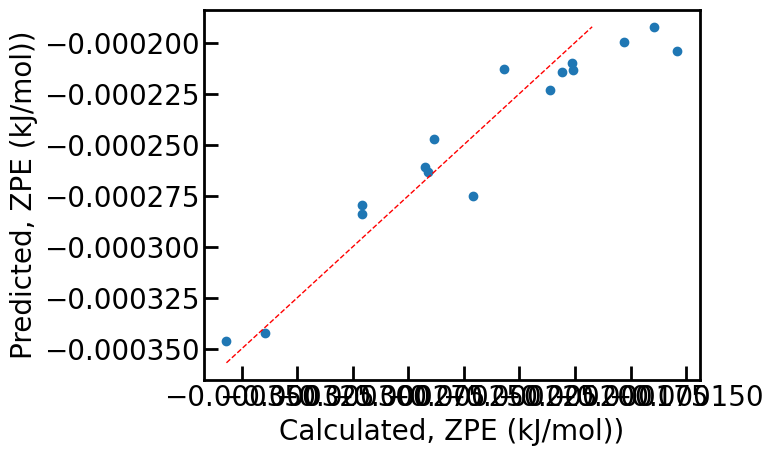

GB 0.8878586306442354
RMSE:  0.09357444613832555
RMSE unscaled:  1.940795962334445e-05
----------------------------------------


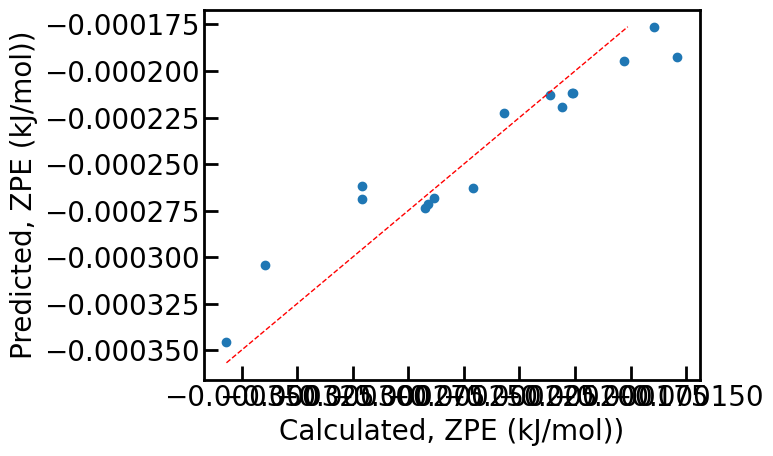

RR 0.9041124206449707
RMSE:  0.08652777082631208
RMSE unscaled:  1.794643251227602e-05
----------------------------------------


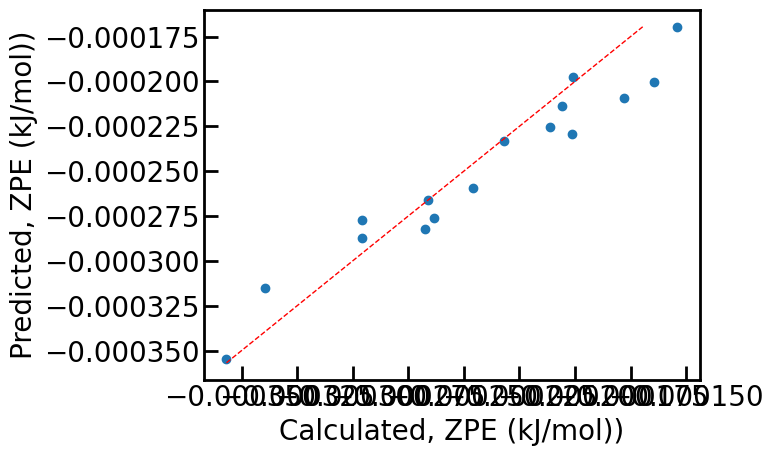

LASSO 0.9243054551078638
RMSE:  0.07687880584441285
RMSE unscaled:  1.5945173295641807e-05
----------------------------------------


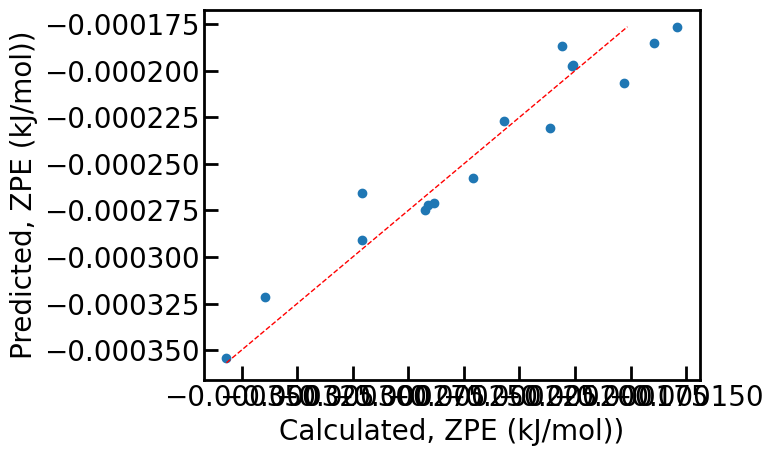

gpr1 0.8797310899628745
RMSE:  0.09690607983433198
RMSE unscaled:  2.009896250843001e-05
----------------------------------------


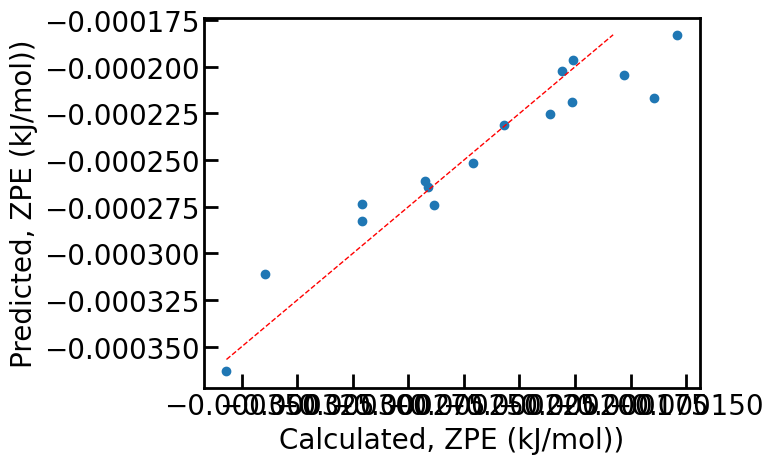

gpr2 0.9686017530190014
RMSE:  0.04951388896428847
RMSE unscaled:  1.0269508369765129e-05
----------------------------------------


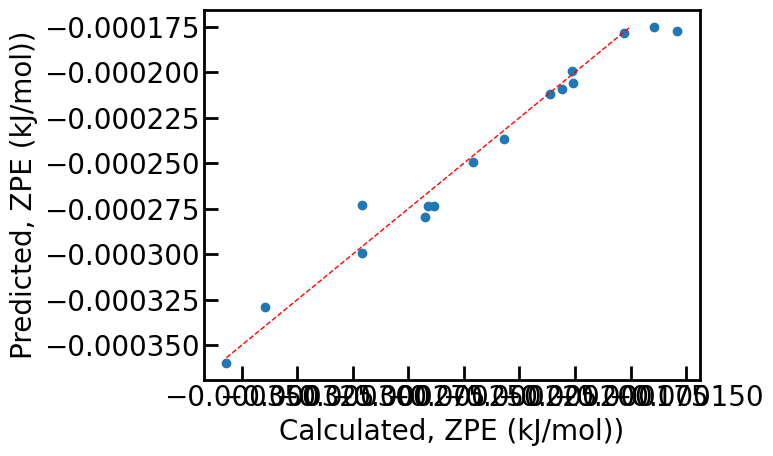

gpr3 0.9749060055419392
RMSE:  0.044264874436960026
RMSE unscaled:  9.180828006558422e-06
----------------------------------------


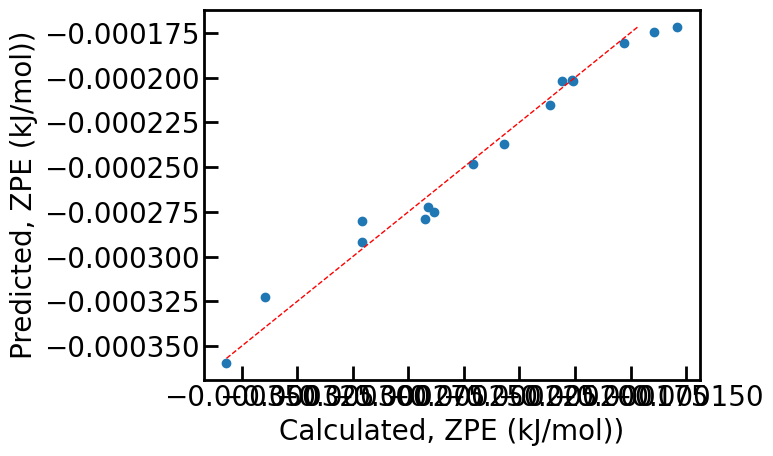

gpr4 0.9373962669128677
RMSE:  0.06991565864810241
RMSE unscaled:  1.4500970468754366e-05
----------------------------------------


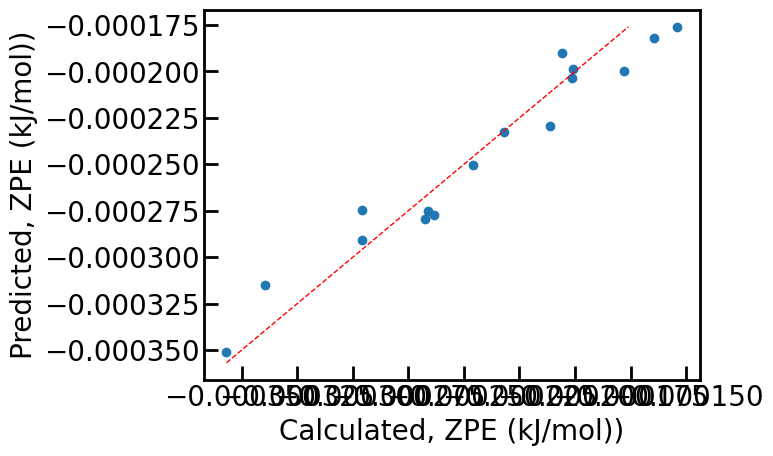

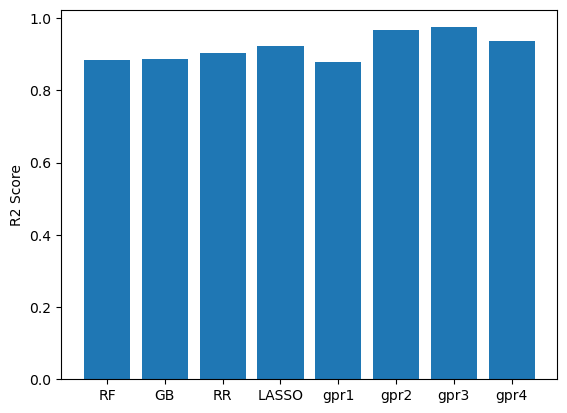

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
28      X_EA  107.076012
4   mean_A2B   99.929262
36      X_Ra   84.202321
2        s_X   82.062188
17       X_Z   79.740038
7   mean_X2X   53.239994
1        s_B   48.879012
34    A_Rvdw   39.367219
5   mean_A2X   37.109735
0        s_A   33.458100
20     A_IEI   26.852117
12     E_coh   26.552367
31    A_ChiA   14.916445
44      B_Hf   13.952951
26      A_EA   12.978514
9    std_A2X   12.535370
41     X_Rho   12.379791
29    A_ChiP   12.150673
37      B_MP   11.671236
10   std_B2X   10.854134
32    B_ChiA    9.258006
38      A_BP    8.834299
14        OF    8.715184
16       B_Z    8.230539
47   X_Kappa    8.186239
45   A_Kappa    7.476652
46   B_Kappa    7.450582
35      B_Ra    7.059603
15       A_Z    6.801723
40     B_Rho    4.850823


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X', 'B_ChiA',
       'A_BP', 'OF', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra',
       'A_Z', 'B_Rho', 'X_MV', 'A_CvM', 'A_G', 'B_EA', 'X_ChiA', 'B_CvM',
       'TF', 'std_X2X', 'A_B', 'std_A2B'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8817531338527299
RMSE:  0.09608800079636817
RMSE unscaled:  1.9929287499998375e-05
----------------------------------------


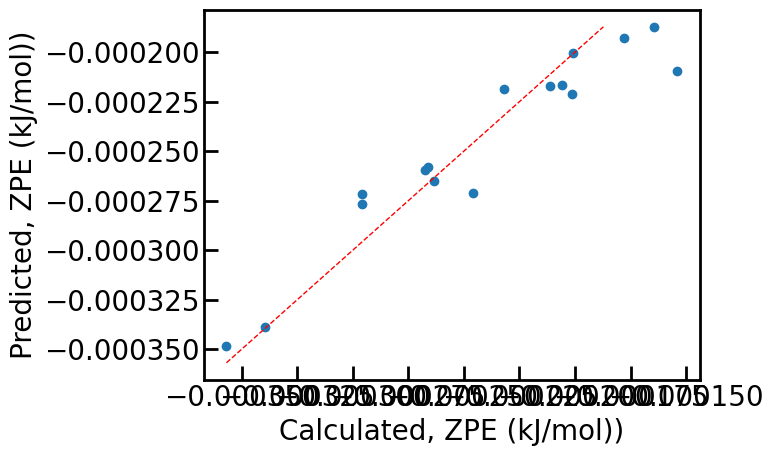

GB 0.8744369718377295
RMSE:  0.09901596586154301
RMSE unscaled:  2.0536566838627578e-05
----------------------------------------


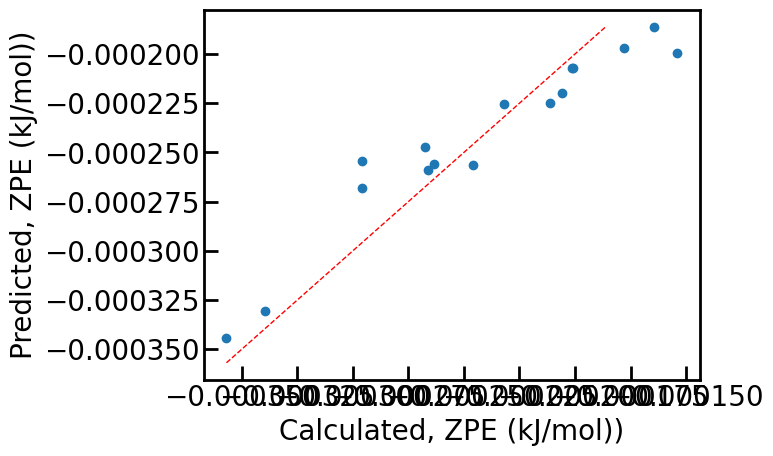

RR 0.9305949040927136
RMSE:  0.07361562728441896
RMSE unscaled:  1.5268368458961245e-05
----------------------------------------


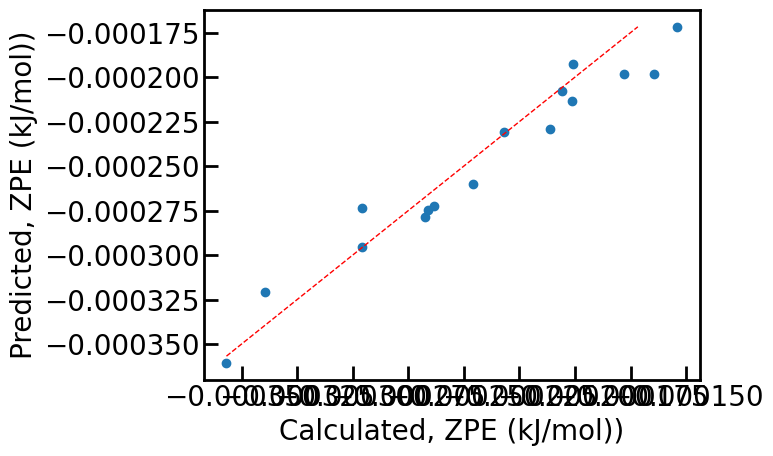

LASSO 0.9288634088924558
RMSE:  0.07452823952853496
RMSE unscaled:  1.5457650280190407e-05
----------------------------------------


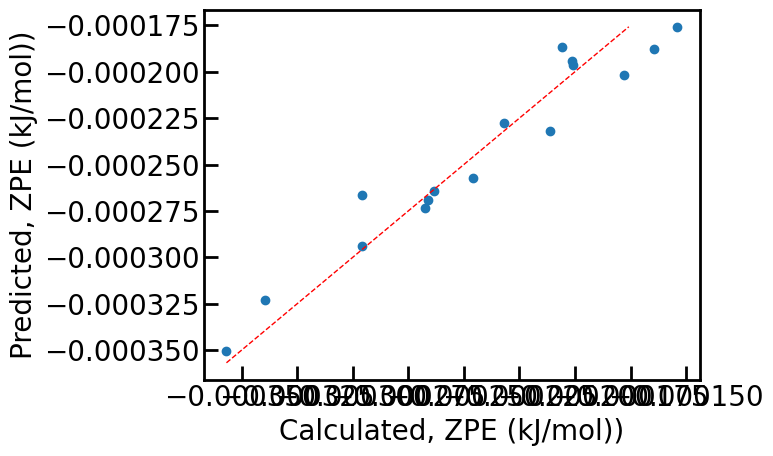

gpr1 0.8863372089434256
RMSE:  0.09420706981411724
RMSE unscaled:  1.9539169961884817e-05
----------------------------------------


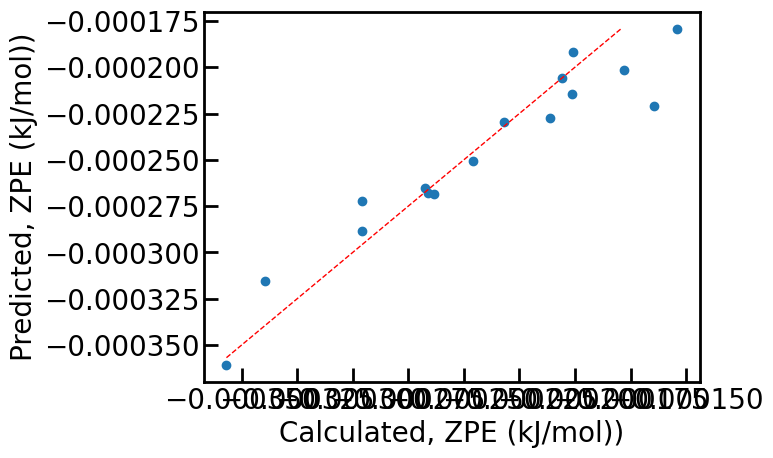

gpr2 0.9621462199010711
RMSE:  0.054366198340013557
RMSE unscaled:  1.1275909458207988e-05
----------------------------------------


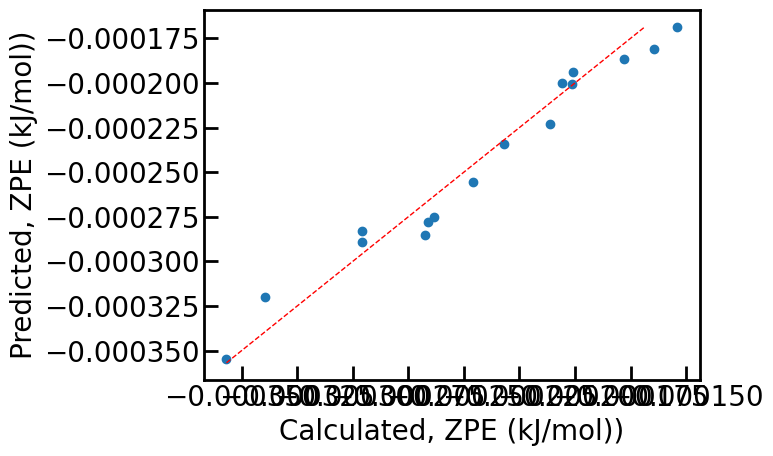

gpr3 0.9633731192319084
RMSE:  0.05347789511050499
RMSE unscaled:  1.109166948754224e-05
----------------------------------------


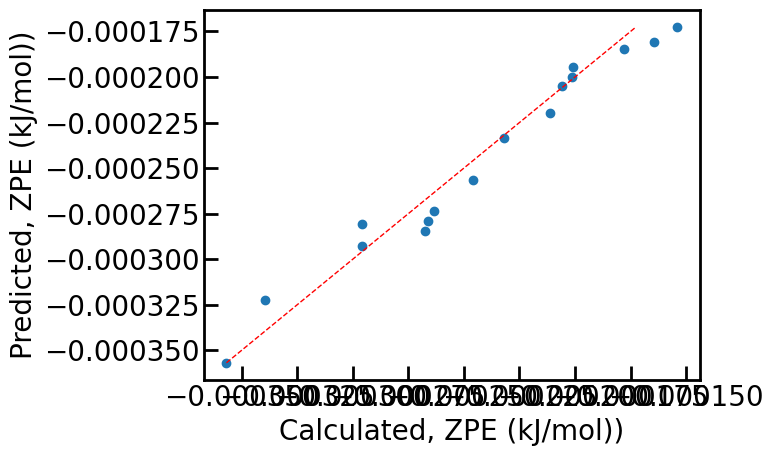

gpr4 0.9366757364964442
RMSE:  0.07031685067083111
RMSE unscaled:  1.4584180350294206e-05
----------------------------------------


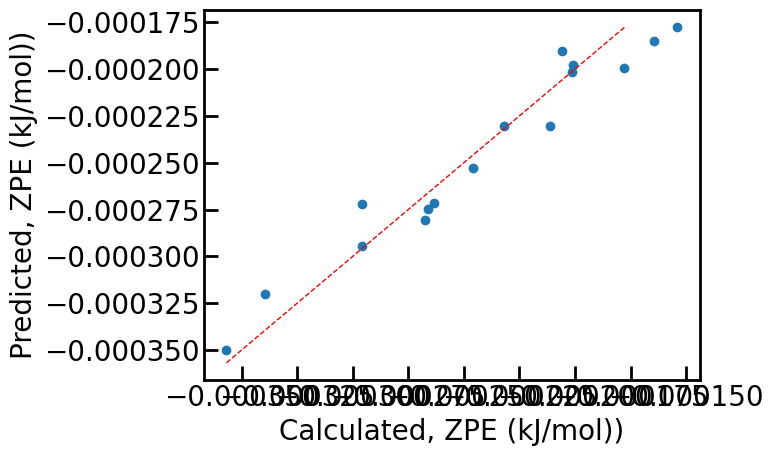

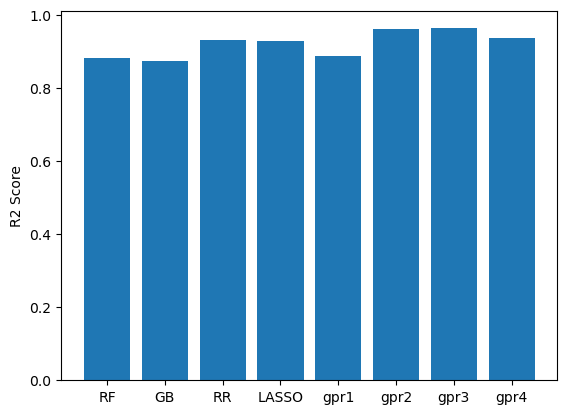

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X', 'B_ChiA',
       'A_BP', 'OF', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra',
       'A_Z', 'B_Rho'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8409657029344959
RMSE:  0.11143451688659443
RMSE unscaled:  2.311225653620118e-05
----------------------------------------


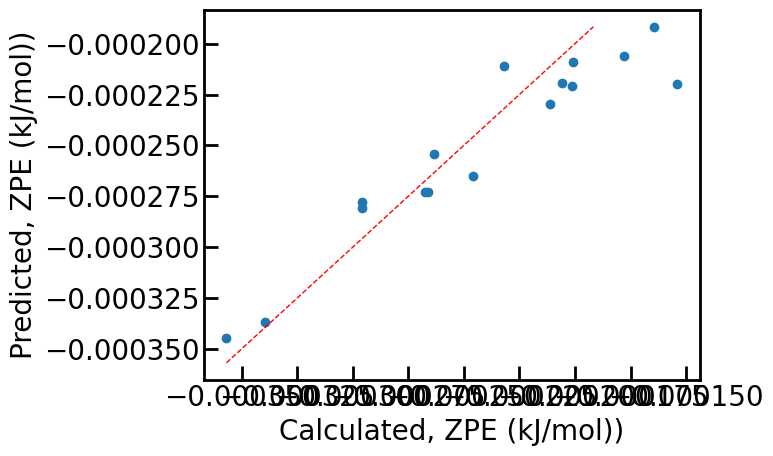

GB 0.8724821611082755
RMSE:  0.09978374734853918
RMSE unscaled:  2.069580980200184e-05
----------------------------------------


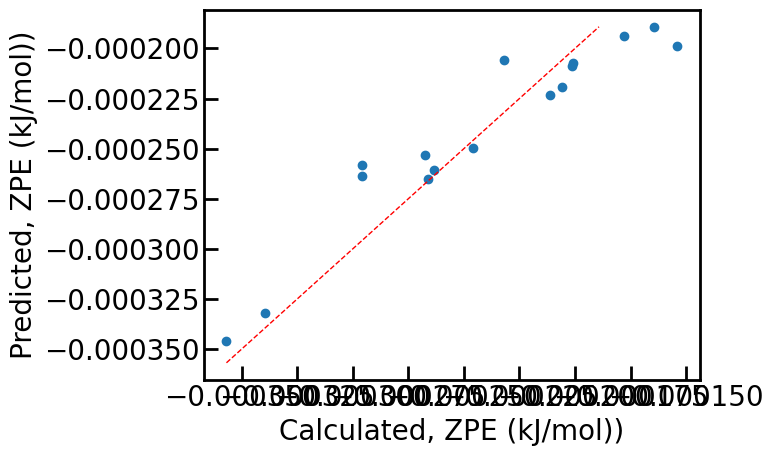

RR 0.9167140843092391
RMSE:  0.08064178276341415
RMSE unscaled:  1.6725639620813494e-05
----------------------------------------


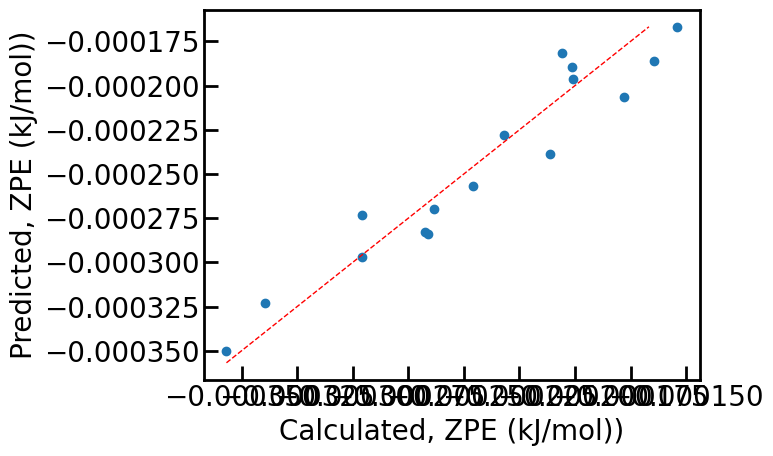

LASSO 0.9198006413311272
RMSE:  0.07913339265024896
RMSE unscaled:  1.6412789525293967e-05
----------------------------------------


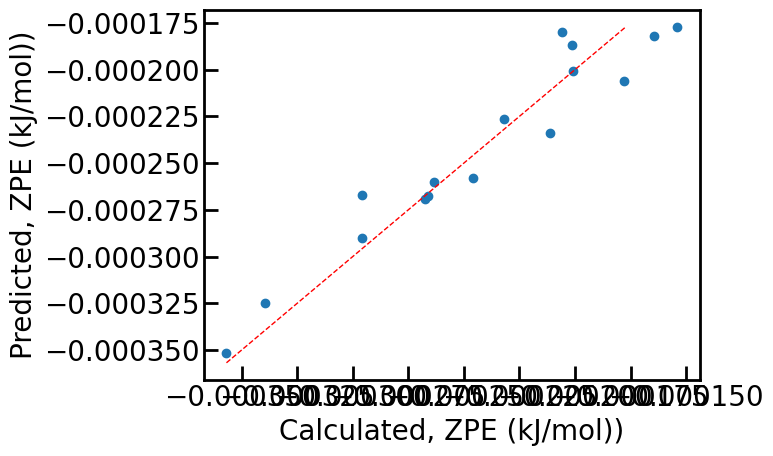

gpr1 0.8685292497418149
RMSE:  0.10131853660010212
RMSE unscaled:  2.1014135253596235e-05
----------------------------------------


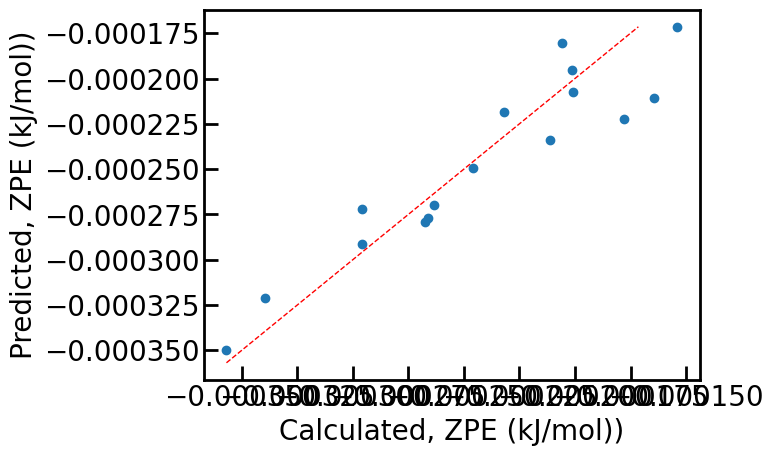

gpr2 0.957290447124133
RMSE:  0.05774798701851524
RMSE unscaled:  1.1977314818705895e-05
----------------------------------------


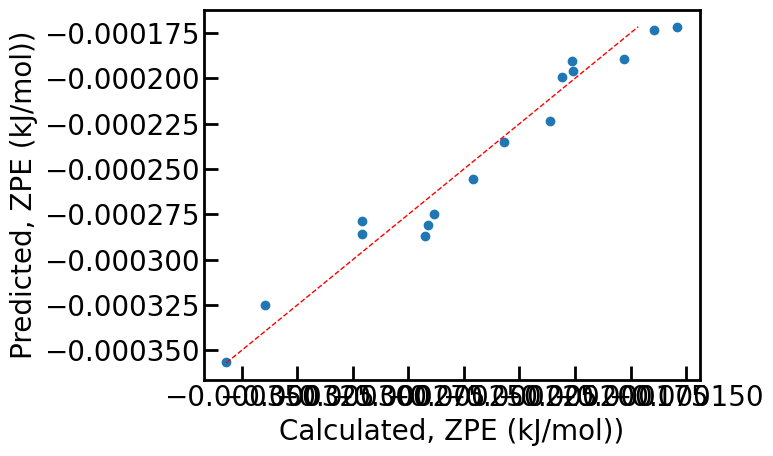

gpr3 0.9533657282100282
RMSE:  0.06034300553433288
RMSE unscaled:  1.2515538838780454e-05
----------------------------------------


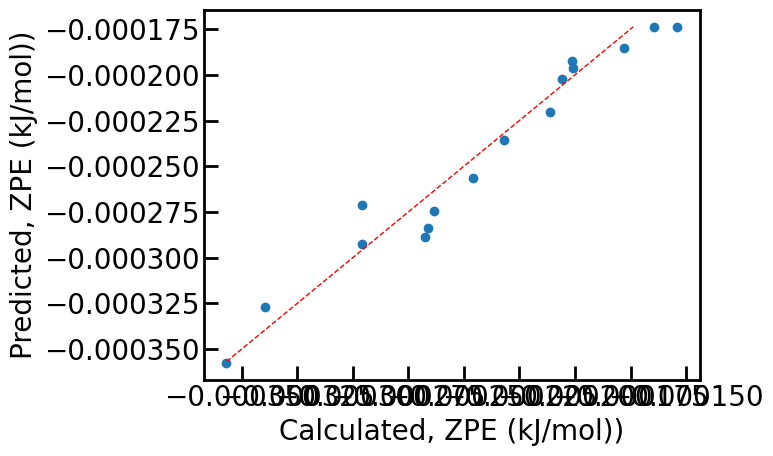

gpr4 0.9237799964854082
RMSE:  0.07714518413577053
RMSE unscaled:  1.600042191678313e-05
----------------------------------------


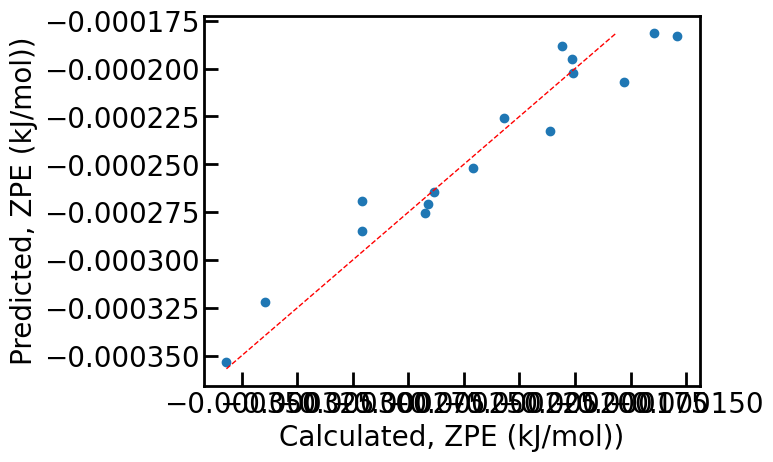

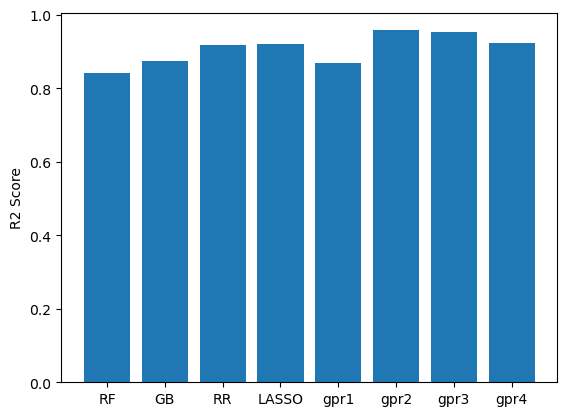

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf',
       'A_EA', 'std_A2X', 'X_Rho', 'A_ChiP', 'B_MP', 'std_B2X'],
      dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8916985472893166
RMSE:  0.0919584153532581
RMSE unscaled:  1.9072784139855003e-05
----------------------------------------


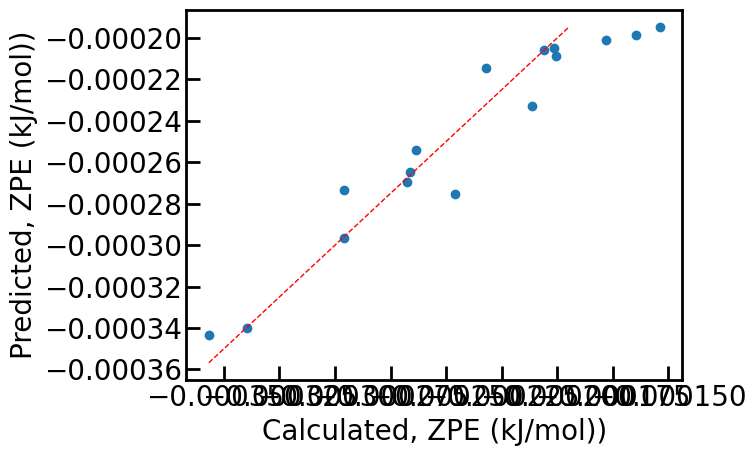

GB 0.851713604056067
RMSE:  0.10760315187150352
RMSE unscaled:  2.2317606067148355e-05
----------------------------------------


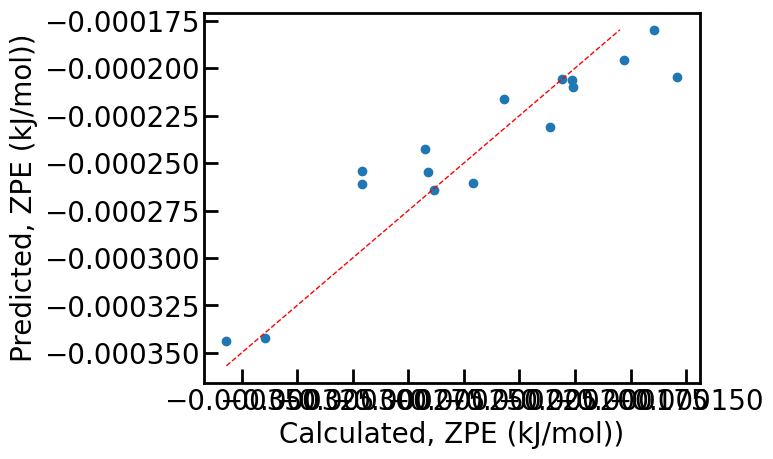

RR 0.9115498820009856
RMSE:  0.0831043096338355
RMSE unscaled:  1.7236383996493683e-05
----------------------------------------


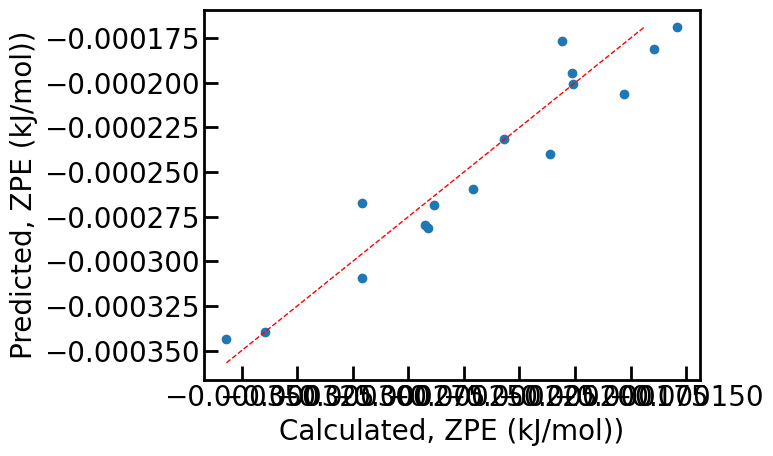

LASSO 0.8872138201971408
RMSE:  0.09384308604362787
RMSE unscaled:  1.946367731819053e-05
----------------------------------------


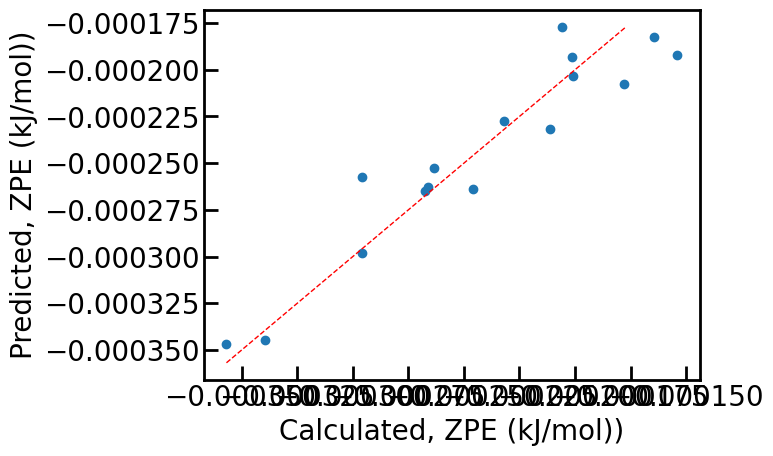

gpr1 0.8828851140731049
RMSE:  0.09562696835137975
RMSE unscaled:  1.9833666318718176e-05
----------------------------------------


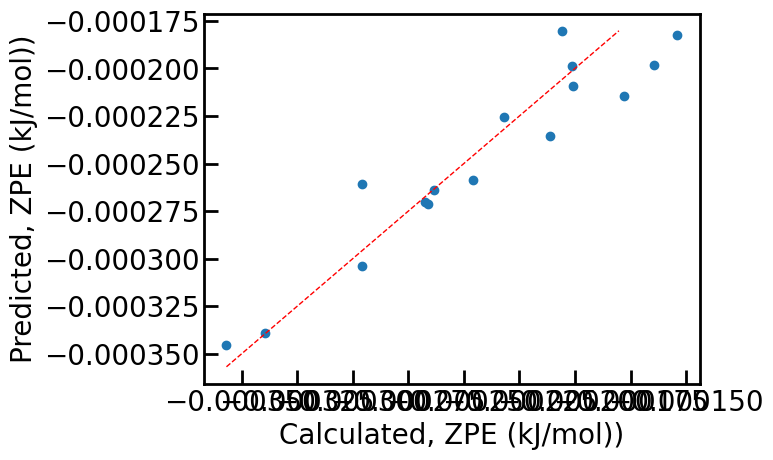

gpr2 0.931385519572302
RMSE:  0.07319513688015132
RMSE unscaled:  1.5181155965328452e-05
----------------------------------------


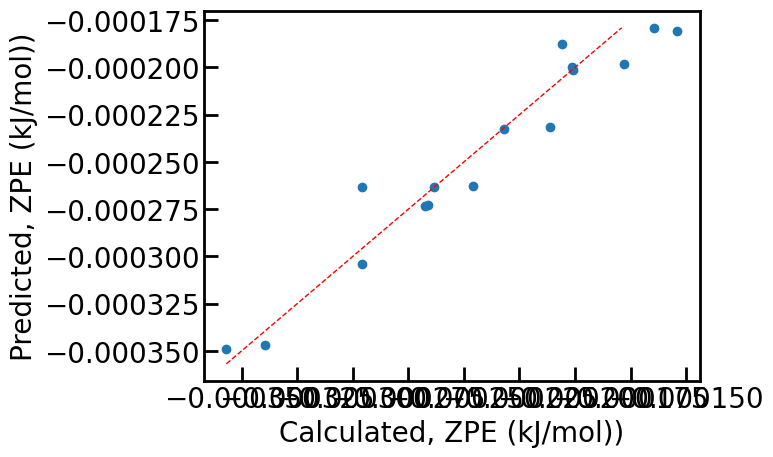

gpr3 0.9523218427438014
RMSE:  0.061014642168745976
RMSE unscaled:  1.2654840723217783e-05
----------------------------------------


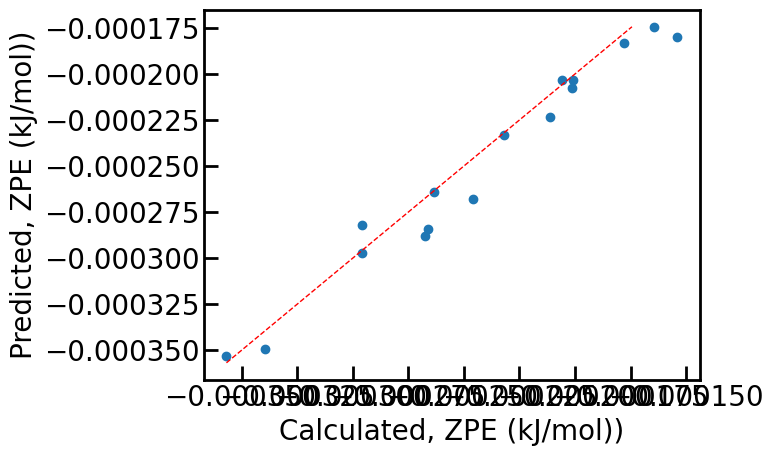

gpr4 0.8942602538928982
RMSE:  0.09086433853326711
RMSE unscaled:  1.8845865364232935e-05
----------------------------------------


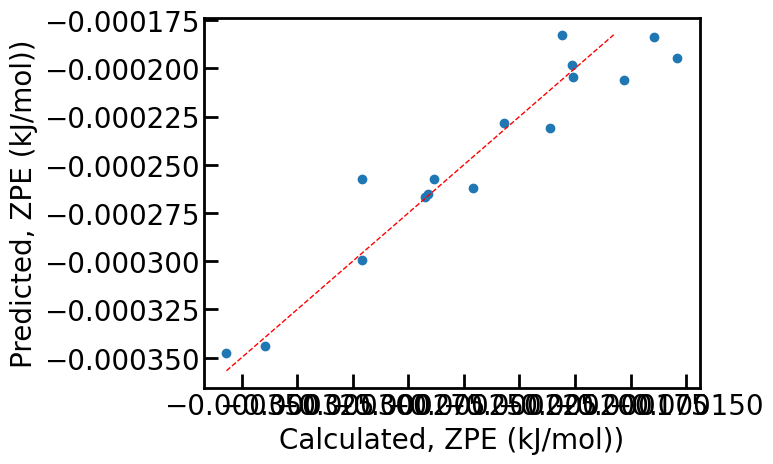

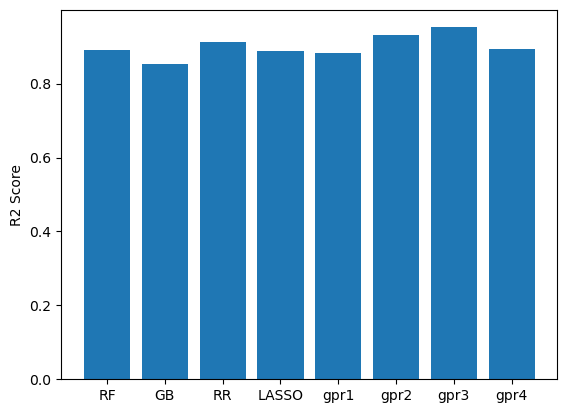

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Ra', 's_X', 'X_Z', 'mean_X2X', 's_B',
       'A_Rvdw', 'mean_A2X', 's_A'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8511800284137445
RMSE:  0.10779657104851555
RMSE unscaled:  2.2357722484960553e-05
----------------------------------------


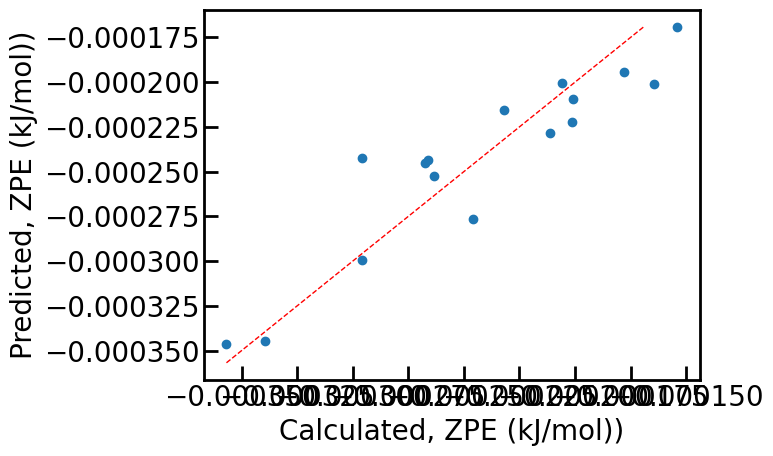

GB 0.8454371879755367
RMSE:  0.10985677434874579
RMSE unscaled:  2.2785022288665955e-05
----------------------------------------


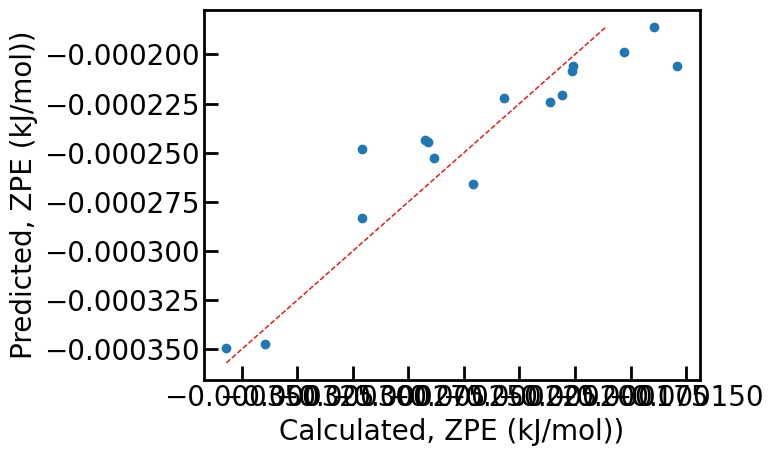

RR 0.9339425575933924
RMSE:  0.07181831560317062
RMSE unscaled:  1.489559411746347e-05
----------------------------------------


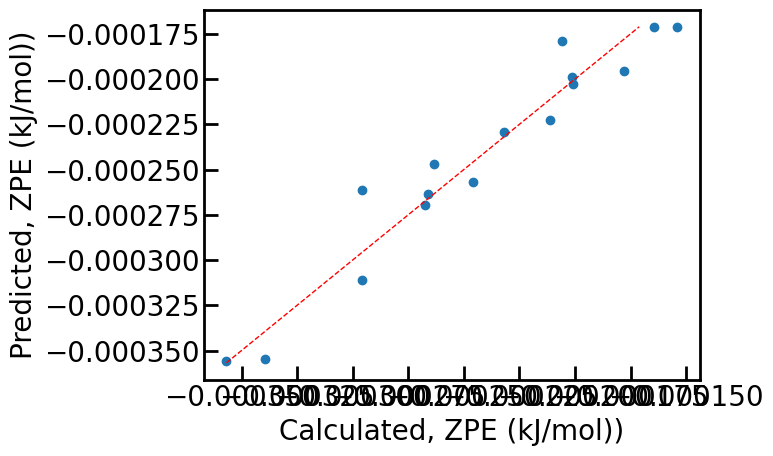

LASSO 0.8853608754158881
RMSE:  0.09461081165446256
RMSE unscaled:  1.9622908692478996e-05
----------------------------------------


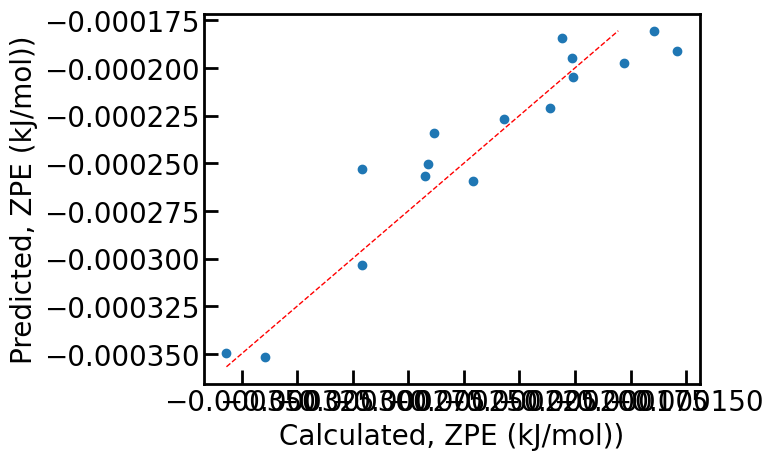

gpr1 0.9008544069616422
RMSE:  0.08798548760261647
RMSE unscaled:  1.8248772622256106e-05
----------------------------------------


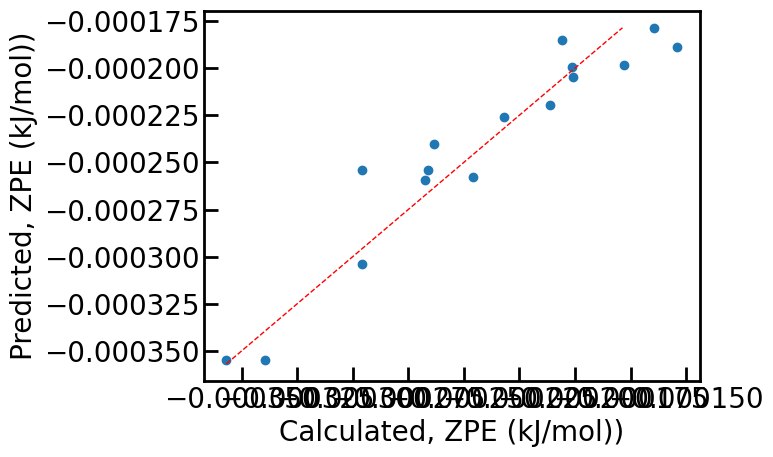

gpr2 0.9331351451190628
RMSE:  0.0722558960209436
RMSE unscaled:  1.4986351193038895e-05
----------------------------------------


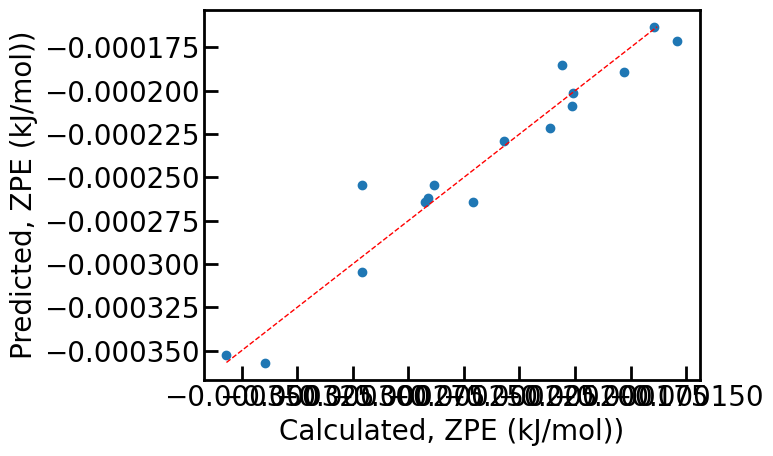

gpr3 0.9750488149418239
RMSE:  0.04413873948375218
RMSE unscaled:  9.154666782207369e-06
----------------------------------------


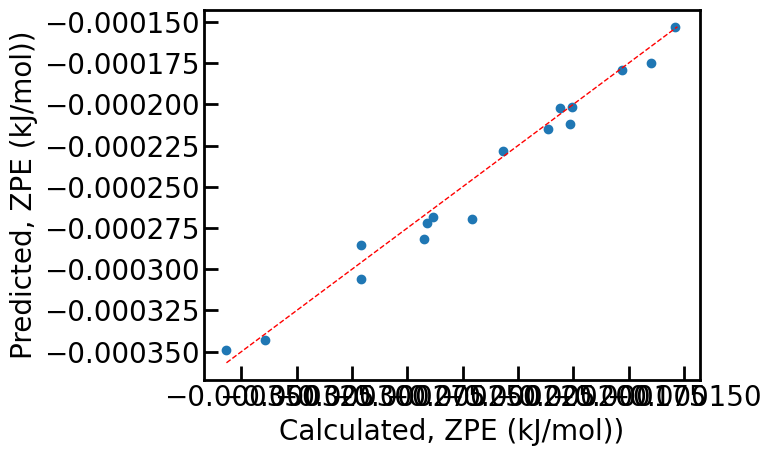

gpr4 0.9189186733618938
RMSE:  0.07956732556772037
RMSE unscaled:  1.6502790085159168e-05
----------------------------------------


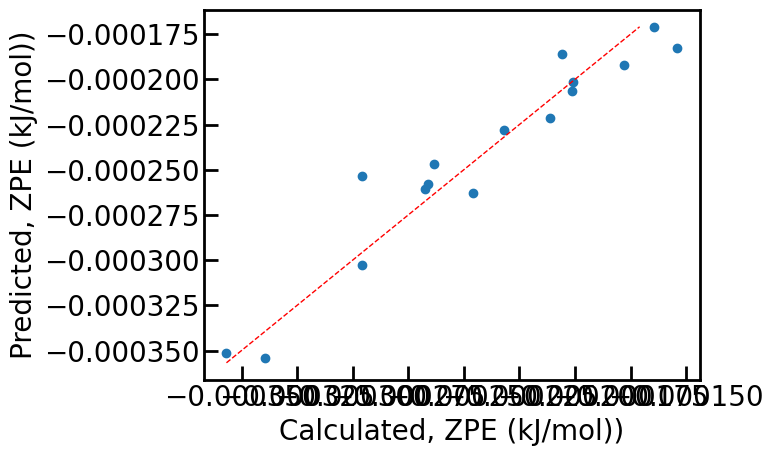

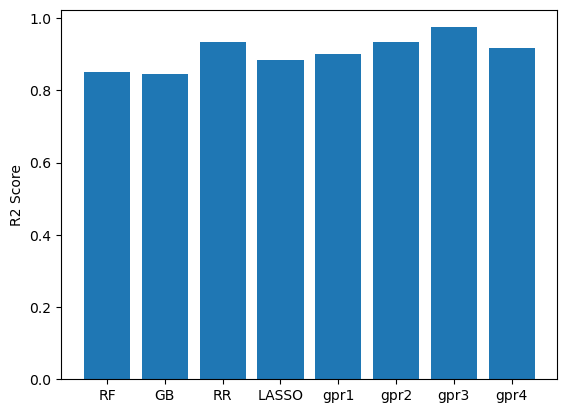

In [41]:
run_models()